###### Olivier Berthier - 2025 - Master Data Science - Université Paris Dauphine PSL   




# Compte rendu projet Case Study - Grand Débat National      






Dans ce rapport, nous analysons un corpus de **87 562** contributions issues du __Grand Débat National__, compilées dans un fichier unique. L’objectif est de caractériser les préoccupations environnementales exprimées par les citoyens et d’examiner comment ces préoccupations se structurent selon le contexte territorial des répondants.  
Nous focalisons spécifiquement l’étude sur la question ouverte: "Si oui, que faites-vous aujourd’hui pour protéger l’environnement et/ou que pourriez-vous faire ?", posée en prolongement de la question fermée: "À titre personnel, pensez-vous pouvoir contribuer à protéger l’environnement". 
Notons que lorsque les contributeurs répondent "non" à la question fermée, aucune réponse n’est attendue à la question ouverte, ce qui se traduit par des valeurs manquantes pour environ 10 % des documents.  
Nous adoptons une perspective territoriale consistant à comparer la distribution des thèmes selon le type de commune des contributeurs. L’objectif est d’identifier d’éventuelles "signatures thématiques" et d’en caractériser l’intensité relative, à partir des poids des sujets, de leurs co‑occurrences et de la tonalité des propos. Cette articulation permet d’explorer la nature concrète des actions évoquées ainsi que les priorités qui se dégagent.  
L’enjeu méthodologique est la mise en œuvre d’un chaînage d’outils de traitement automatique du langage et d’exploration thématique sur un corpus volumineux.  


# Chargement du fichier principal

Dans le script suivant, nous chargeons le fichier data/LA_TRANSITION_ECOLOGIQUE.csv et formatons la colonne *authorZipCode* en chaînes de 5 caractères en ajoutant des zéros à gauche afin de garantir une structure de code postal uniforme (par exemple des codes postaux tels que '1205' deviennent '01205' pour correspondre au format français). 

In [1]:
# import fichier principal

import pandas as pd
df = pd.read_csv("data/LA_TRANSITION_ECOLOGIQUE.csv")

# Transformer zipcode en string et ajouter des zéros à gauche
df['authorZipCode'] = (
    df['authorZipCode']
    .astype(str)  # Conversion en string
    .str.zfill(5)  # Remplissage avec des zéros à gauche
)

/tmp/ipykernel_151798/3896239343.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/LA_TRANSITION_ECOLOGIQUE.csv")


# Étape de Lemmatisation des documents

Dans le script suivant, nous sélectionnons la question d'intérêt, initialisons le modèle français *fr_core_news_md* de **spaCy** ("md" pour medium, nous utiliserons le modèle long plus bas pour des tâches plus complexes), puis appliquons une fonction de lemmatisation qui convertit chaque réponse textuelle en une liste de lemmes (nouvelle colonne *lemmas_clean*).  

Justification du choix de spaCy plutôt que **NLTK** (autre référence pour la lemmatisation en Python) :  

- Qualité de la lemmatisation en français: spaCy fournit des modèles dédiés au français (fr_core_news_md/lg) entraînés sur des corpus annotés, offrant des lemmes, POS et dépendances de bonne qualité, alors que NLTK ne propose pas nativement de lemmatiseur robuste pour le français.  
- Pipeline intégré et cohérent: la tokenisation, l’étiquetage syntaxique et la lemmatisation sont conçus pour fonctionner ensemble dans spaCy, ce qui réduit les les incohérences fréquentes avec des briques disparates sous NLTK (d'après retour d'expériences *stackoverflow*)
- Meilleur passage à l’échelle de spaCy qui permet un traitement par flux avec *batch_size*, mieux adapté à un corpus de 87 562 lignes. NLTK est réputé plus lent pour ce type de traitement massif.  
- Gestion des spécificités du français: spaCy gère mieux les contractions et l’orthographe (ex. l’, d’, qu’), ce qui améliore la qualité des lemmes et la normalisation en amont d’analyses thématiques.

Nous avons dans un premier temps prototypé le pipeline avec NLTK et constaté que la qualité des lemmes en français, le débit de traitement et la gestion des contractions étaient en deçà de ce que permet spaCy sur notre corpus.

In [ ]:
import pandas as pd
import spacy
from tqdm import tqdm

# colonne d'intérêt
col = "QUXVlc3Rpb246MTQ5 - Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?"

# Charger le modèle spaCy 
nlp = spacy.load("fr_core_news_md")

# lemmatisation 
def spacy_lemmatizer(text):
    return [token.lemma_ for token in nlp(text)]

# Ajouter la colonne lemmas
tqdm.pandas()  
df['lemmas'] = df[col].fillna('').progress_apply(spacy_lemmatizer)
df_lemmas = df.copy()
# Affichage d'exemples pour vérification après lemmatisation (exclu docs vides)
mask = df_lemmas['lemmas'].apply(lambda x: isinstance(x, list) and len(x) > 0)
print(df_lemmas.loc[mask, [col, 'lemmas']].head(4))

100%|██████████| 87562/87562 [14:41<00:00, 99.36it/s]  


  QUXVlc3Rpb246MTQ5 - Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?  \
4      En consommant autrement, en vivant autrement.                                                                      
5  en consommant moins de produits manufacturé à ...                                                                      
6  Plus aucun pesticide , marche à pied le plus s...                                                                      
7  Mode de déplacement "doux". Voiture propre. Tr...                                                                      

                                              lemmas  
4  [en, consommer, autrement, ,, en, vivre, autre...  
5  [en, consommer, moins, de, produit, manufactur...  
6  [plus, aucun, pesticide, ,, marche, à, pied, l...  
7  [mode, de, déplacement, ", doux, ", ., voiture...  


Nous transformons la colonne *lemmas_clean* en convertissant chaque entrée en une seule chaîne de caractères afin d’avoir un texte continu par ligne :   
- en homogénéisant la casse en minuscules pour éviter de considérer “Énergie” et “énergie” comme des termes distincts ;   
- en supprimant la ponctuation et les symboles non alphanumériques, ce qui limite le bruit lors de la tokenisation et simplifie le comptage ;  
- en normalisant les espaces pour obtenir un texte régulier et prêt à être vectorisé.


In [ ]:
# Suppression de la ponctuation dans la colonne lemmas (-> new col lemmas_clean)
df_lemmas["lemmas_clean"] = df_lemmas["lemmas"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

# Supprime la ponctuation résiduelle 
df_lemmas["lemmas_clean"] = (
    df_lemmas["lemmas_clean"]
    .str.lower()
    .str.replace(r"[^\w\s]", " ", regex=True)   
    .str.replace(r"\s+", " ", regex=True)       # remplace plusieurs espaces par un seul
    .str.strip()
)

# Affichage xemples pour vérif 
mask = df_lemmas['lemmas'].apply(lambda x: isinstance(x, list) and len(x) > 0)
print(df_lemmas.loc[mask, ['lemmas', 'lemmas_clean']].head(4))

                                              lemmas  \
4  [en, consommer, autrement, ,, en, vivre, autre...   
5  [en, consommer, moins, de, produit, manufactur...   
6  [plus, aucun, pesticide, ,, marche, à, pied, l...   
7  [mode, de, déplacement, ", doux, ", ., voiture...   

                                        lemmas_clean  
4          en consommer autrement en vivre autrement  
5  en consommer moins de produit manufacturé à le...  
6  plus aucun pesticide marche à pied le plus sou...  
7  mode de déplacement doux voiture propre tri un...  


# Word cloud simple sur les lemmes (unigramme)

Dans le script suivant, nous analysons notre corpsu lemmatisé, comptons les mots les plus représentatifs, puis visualisons les termes les plus présents sous forme de nuage de mots.

Nous parcourons le texte par blocs (500000) afin de traiter un volume important sans saturer la mémoire.
Nous passons chaque bloc dans le modèle de langue française (*fr_core_news_md*) pour obtenir des tokens, puis nous conservons uniquement les mots porteurs de sens (pas de mots‑vides, pas de ponctuation, pas de très courts fragments).
Nous cumulons les fréquences de ces mots à l’échelle de tout le corpus pour mesurer leur importance relative.
Nous générons ensuite un nuage de mots qui met visuellement en avant les termes les plus fréquents (les 200 premiers), afin d’obtenir un aperçu rapide des thématiques dominantes.
  
Note : La gestion des **soptwwords** se fait à travers la fonction **if not token.is_stop** qui utilise la liste de stopwords intégrée de SpaCy français
(filtre automatiquement "le", "de", "et", "être", "avoir", etc.).

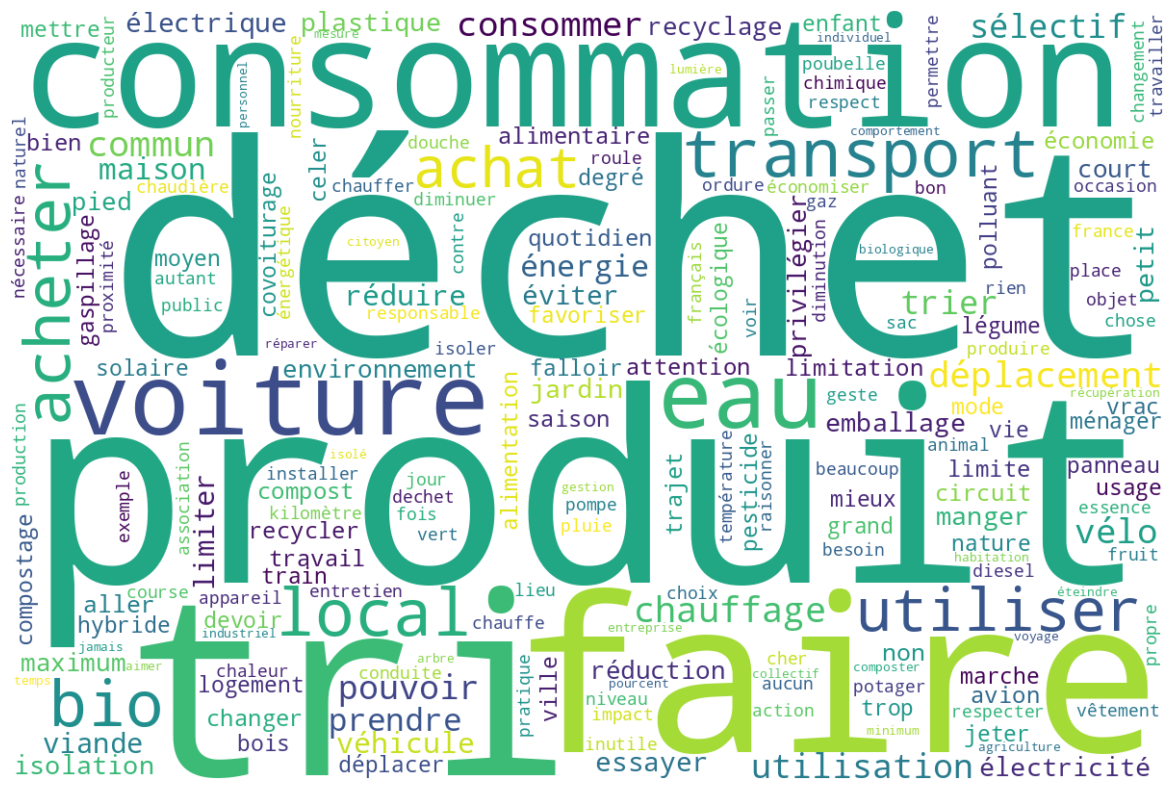

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from collections import Counter

nlp = spacy.load("fr_core_news_md")

def generate_wordcloud_from_large_text(text, max_words=200):
    # Traitement par morceaux
    chunk_size = 500000
    word_counts = Counter()
    
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        doc = nlp(chunk)
        chunk_words = [token.text.lower() for token in doc 
                      if not token.is_stop 
                      and not token.is_punct 
                      and len(token.text) > 2]
        word_counts.update(chunk_words)
    
    # Génération du word cloud
    wc = WordCloud(width=1200, height=800, 
                  background_color='white',
                  max_words=max_words)
    wc.generate_from_frequencies(word_counts)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return wc
                    
# Utilisation
text = " ".join(df_lemmas["lemmas_clean"].astype(str))
generate_wordcloud_from_large_text(text)


Émergent très nettement des thèmes centrés sur la gestion des déchets et les gestes individuels: "déchet", "tri", "trier", "recycler", "utiliser" et le verbe générique "faire" dominent, indiquant une forte saillance des pratiques de tri et de réduction des ordures.  
Les préoccupations liées aux modes de consommation apparaissent via "produit", "consommation", "acheter", "local", "bio", "vrac", signalant un accent mis sur l’achat responsable, le circuit court et la baisse du gaspillage.  
Les enjeux de mobilité et d’énergie sont également présents avec "voiture", "transport", "électrique", "véhicule", "chauffage", "électricité", "réduire/limiter", suggérant l'importance des intentions de limitation de l’usage automobile, de recours aux transports en commun et d’amélioration de la performance énergétique du logement.  
Enfin, "eau", "viande", "plastique" et "emballage" pointent des leviers spécifiques relatifs à une consommation sobre et responsable.  
    
Ce *wordcloud*, fondé sur des fréquences unigrammes, met donc en évidence des leviers d’action concrets, mais il ne renseigne ni sur le contexte (opinions positives/négatives) ni sur les associations multi-mots ("tri sélectif", "voiture électrique", "achat local"), ce qui motive des analyses complémentaires par bigrammes/trigrammes.

#  Wordcloud par pondération TF-IDF 

Dans le script suivant, nous générons un nuage de **n-grammes** (1 à 3 mots) pondérés par **TF‑IDF** pour valoriser les cooccurrences spécifiques au corpus.  
TF‑IDF pondère la fréquence par la rareté dans le corpus: un terme fréquent dans un document mais rare à l’échelle des documents sera mis en avant, tandis qu’un terme courant partout sera ignoré. Le but est ici de valoriser la spécificité thématique.

/home/algernon/projets/Case_Study/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu'] not in stop_words.
  warnings.warn(


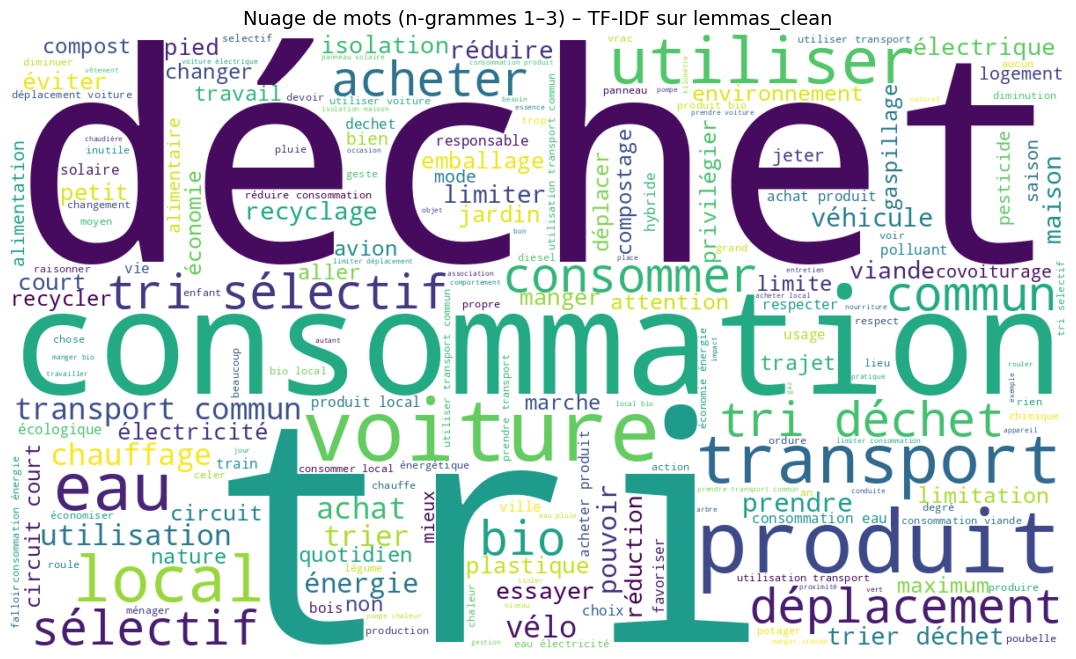

In [ ]:
# 1-gramme à 3-grammes avec TF-IDF et WordCloud
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# Corpus
text_col = "lemmas_clean"
corpus = (
    df_lemmas[text_col]
    .fillna("")
    .astype(str)
    .str.strip()
)
corpus = corpus[corpus.str.len() > 0]

# Stopwords: SpaCy FR + ajouts (set -> liste)
sw = set(spacy.lang.fr.STOP_WORDS)
sw.update([
    "oui", "si", "etc", "faire", "faut", "être", "etre", "tout", "tous", "plus",
    "moins", "mettre", "aussi", "comme", "mes", "ma", "le", "les", "la", "nos",
    "ses", "des", "de", "il", "ils", "elle", "elles", "pour", "qui", "que", "quoi",
    "quand", "comment", "parce", "avec", "sans", "donc", "car", "cela", "ça", "ca",
    "c'est", "cest", "l'", "l’", "d'", "d’", "j'", "j’", "c'", "c’", "n'", "n’", "t'", "t’",
])
stop_words = sorted(sw)  

# Préprocesseur (normalise les apostrophes et espaces)
def preproc(s: str) -> str:
    s = s.replace("’", "'")
    s = re.sub(r"\s+", " ", s)
    return s

# TF‑IDF n‑grammes (1–3)
vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 3),
    stop_words=stop_words,   
    lowercase=False,         
    token_pattern=r"(?u)\b[\w'-]{2,}\b",
    preprocessor=preproc,
    min_df=5,
    max_features=10000
)

X = vectorizer.fit_transform(corpus.values)
terms = vectorizer.get_feature_names_out()
scores = np.asarray(X.sum(axis=0)).ravel()

# Top-N pour le WordCloud
TOP_N = 500
top_idx = np.argsort(scores)[::-1][:TOP_N]
freqs_top = {terms[i]: float(scores[i]) for i in top_idx}

# Top-N pour le WordCloud
wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    prefer_horizontal=0.9,
    collocations=False,
    normalize_plurals=False,
    random_state=42,
)
wc = wc.generate_from_frequencies(freqs_top)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots (n‑grammes 1–3) – TF‑IDF sur lemmas_clean", fontsize=14)
plt.show()

Les unigrammes dominent l’essentiel de l’information dans ce corpus. Les bi/tri‑grammes les plus visibles ("tri sélectif", "transport commun", "produit local", "panneau solaire", "circuit court", "voiture électrique") servent surtout à préciser les sous‑thèmes.

# Wordcloud sur les bigrammes 

Contrairement aux unigrammes, les bigrammes révèlent les associations réellement saillantes dans les réponses et permettent de mieux cerner les intentions d’action en exprimant directement les pratiques évoquées par les répondants.

/home/algernon/projets/Case_Study/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu'] not in stop_words.
  warnings.warn(


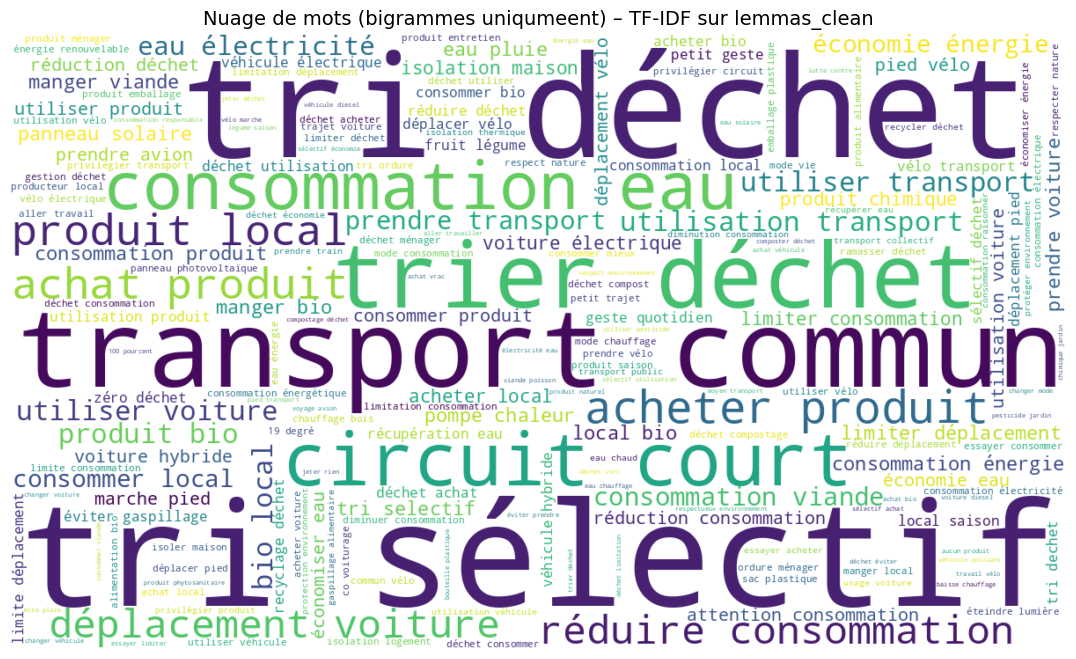

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# Corpus
text_col = "lemmas_clean"
corpus = (
    df_lemmas[text_col]
    .fillna("")
    .astype(str)
    .str.strip()
)
corpus = corpus[corpus.str.len() > 0]

# Stopwords: SpaCy FR + ajouts (set -> liste)
sw = set(spacy.lang.fr.STOP_WORDS)
sw.update([
    "oui", "si", "etc", "faire", "faut", "être", "etre", "tout", "tous", "plus",
    "moins", "mettre", "aussi", "comme", "mes", "ma", "le", "les", "la", "nos",
    "ses", "des", "de", "il", "ils", "elle", "elles", "pour", "qui", "que", "quoi",
    "quand", "comment", "parce", "avec", "sans", "donc", "car", "cela", "ça", "ca",
    "c'est", "cest", "l'", "l’", "d'", "d’", "j'", "j’", "c'", "c’", "n'", "n’", "t'", "t’",
])
stop_words = sorted(sw)  

# Préprocesseur (normalisation apostrophes et espaces)
def preproc(s: str) -> str:
    s = s.replace("’", "'")
    s = re.sub(r"\s+", " ", s)
    return s

# TF‑IDF 2‑grammes uniquement
vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(2, 2),  # Bigrammes seulement
    stop_words=stop_words,   
    lowercase=False,         
    token_pattern=r"(?u)\b[\w'-]{2,}\b",
    preprocessor=preproc,
    min_df=5,
    max_features=10000
)

X = vectorizer.fit_transform(corpus.values)
terms = vectorizer.get_feature_names_out()
scores = np.asarray(X.sum(axis=0)).ravel()

# Top-N pour le WordCloud
TOP_N = 500
top_idx = np.argsort(scores)[::-1][:TOP_N]
freqs_top_bigram = {terms[i]: float(scores[i]) for i in top_idx}

# WordCloud
wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    prefer_horizontal=0.9,
    collocations=False,
    normalize_plurals=False,
    random_state=42,
)
wc = wc.generate_from_frequencies(freqs_top_bigram)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots (bigrammes uniqumeent) – TF‑IDF sur lemmas_clean", fontsize=14)
plt.show()

Dans le nuage de mots fondé sur les bigrammes TF‑IDF des lemmes, trois pôles thématiques principaux se dégagent. D’abord, la gestion des ordures ménagères, avec "tri déchet" et "tri sélectif" au premier plan, signe d’une focalisation forte sur les gestes de tri et de réduction des déchets.  
Ensuite, la mobilité quotidienne, où "transport commun", "utiliser voiture" et "déplacement voiture" opposent usages individuels et alternatives collectives.  
Enfin, les modes de consommation responsables ressortent via "circuit court", "produit local", "produit bio", "achat produit", complétés par des leviers de sobriété comme "réduire consommation", "consommation eau" et des solutions énergétiques telles que "panneau solaire" ou "économie énergie" . Dans l’ensemble, ces bigrammes mettent en évidence des actions concrètes et proches du quotidien (tri, achats, déplacements) davantage que des mesures structurelles.  
Néanmoins, le wordcloud ne renseigne ni sur la polarité (adhésion/critique) ni sur les contextes d’énonciation; une analyse complémentaire par cooccurrences pondérées, dépendances syntaxiques (ex. "limiter vitesse ", "privilégier vélo ") et segmentation par profils (code postal, type de participant) permettrait d’affiner l’interprétation.

**Approche alternative** :  

Contrairement à l’approche précédente basée sur une détection purement statistique de bigrammes (via **TfidfVectorizer** avec **ngram_range=(2,2)**), ce script propose une extraction linguistique des groupes nominaux et relations syntaxiques, en exploitant les dépendances grammaticales identifiées par spaCy. Cette méthode permet de capturer des expressions plus sémantiquement cohérentes que de simples paires de mots adjacents, tout en réduisant le bruit introduit par des associations fortuites.

L’algorithme s’appuie sur le découpage en **chunks nominaux** (ex. "tri sélectif", "circuit court") : spaCy identifie naturellement ces groupes grâce à l’analyse en dépendances, évitant ainsi des bigrammes artificiels comme "le tri" ou "pour réduire".

Extraction des expressions multi-mots…
Extraction terminée.


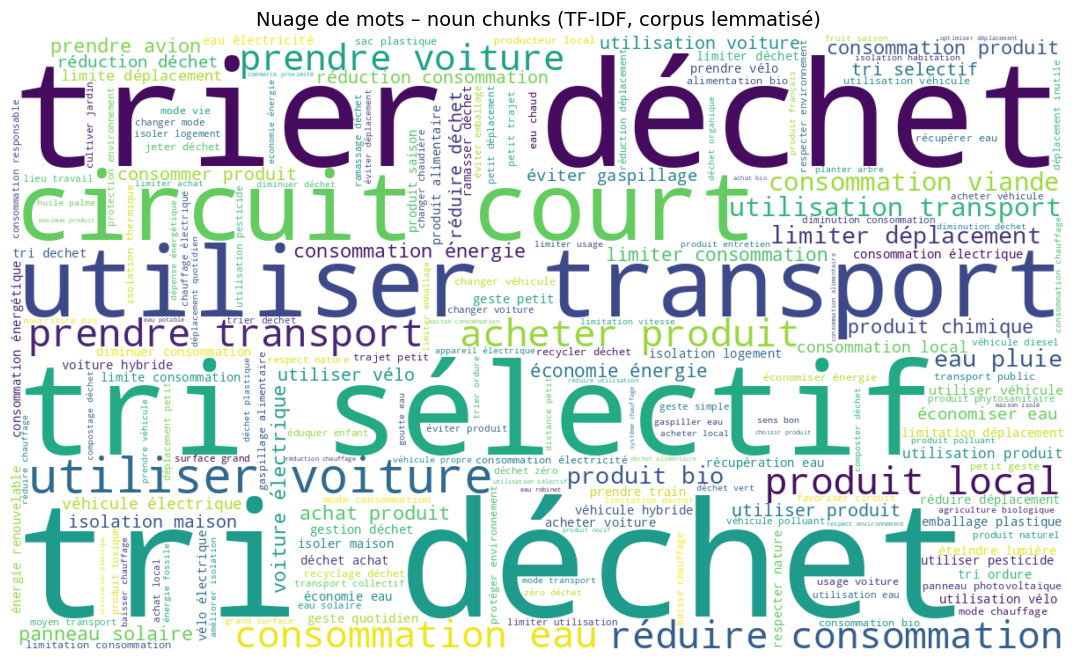

In [ ]:
# Bigrammes version noun chunks
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# spaCy 
nlp = spacy.load("fr_core_news_md", exclude=["lemmatizer"])
nlp.add_pipe("sentencizer", first=True)

# Stopwords 
sw = set(spacy.lang.fr.STOP_WORDS)
sw.update([
    "je","tu","il","elle","nous","vous","ils","elles","on",
    "me","te","se","moi","toi","lui","leur","eux",
    "mon","ma","mes","ton","ta","tes","son","sa","ses",
    "notre","nos","votre","vos","leur","leurs",
    "le","la","les","un","une","des","du","de","d","l","au","aux","ce","cet","cette","ces",
    "oui","si","etc","faire","faut","etre","être","plus","moins","aussi","comme",
    "quand","comment","parce","avec","sans","donc","car","cela","ça","cest","c'", "c’",
    "qu","ne","pas"
])

def preproc(s: str) -> str:
    s = (s or "").replace("’", "'")
    s = re.sub(r"\s+", " ", s)
    return s.strip()

# POS/dépendances à utiliser (sur texte déjà lemmatisé)
CONTENT_POS = {"NOUN", "ADJ", "PROPN"}
EDGE_POS_TO_DROP = {"DET", "PRON", "ADP", "PART", "SCONJ"}

def strip_edges(tokens):
    i, j = 0, len(tokens)
    while i < j and (tokens[i].is_stop or tokens[i].pos_ in EDGE_POS_TO_DROP or tokens[i].text.lower() in sw):
        i += 1
    while j > i and (tokens[j-1].is_stop or tokens[j-1].pos_ in EDGE_POS_TO_DROP or tokens[j-1].text.lower() in sw):
        j -= 1
    return [t for t in tokens[i:j] if not t.is_punct]

def tokens_to_key(tokens):
    toks = [t.text.lower() for t in tokens
            if (t.pos_ in CONTENT_POS) and (not t.is_stop) and (t.text.strip() not in {"", "'", "’"})]
    return "_".join(toks) if len(toks) >= 2 else ""

def extract_phrases(doc):
    phrases = []

    # nettoyoyage noun_chunks → ex. "tri_sélectif", "circuit_court"
    for np_ in doc.noun_chunks:
        kept = strip_edges(list(np_))
        key = tokens_to_key(kept)
        if key:
            phrases.append(key)

    # NOUN + nmod(de) → "réduction_déchet", "économie_énergie"
    for head in doc:
        if head.pos_ == "NOUN":
            for child in head.children:
                if child.dep_ == "nmod":
                    if any(t.dep_ == "case" and t.text.lower() == "de" for t in child.children):
                        a = head.text.lower()
                        b = child.text.lower()
                        if a not in sw and b not in sw:
                            phrases.append(f"{a}_{b}")
                # 2b) NOUN + ADJ → "tri_sélectif", "vélo_électrique"
                if child.dep_ == "amod" and child.pos_ == "ADJ":
                    a = head.text.lower()
                    b = child.text.lower()
                    if a not in sw and b not in sw:
                        phrases.append(f"{a}_{b}")

    # VERB + OBJ → "trier_déchet", "réduire_consommation"
    for v in doc:
        if v.pos_ in {"VERB", "AUX"}:
            for ch in v.children:
                if ch.dep_ == "obj" and ch.pos_ in {"NOUN", "PROPN"}:
                    a = v.text.lower()
                    b = ch.text.lower()
                    if a not in sw and b not in sw:
                        phrases.append(f"{a}_{b}")

    # dédoublonnage en conservant l'ordre
    seen, out = set(), []
    for p in phrases:
        if p and p not in seen:
            seen.add(p)
            out.append(p)
    return out

# Corpus déjà lemmatisé 
text_col = "lemmas_clean"
corpus = (
    df_lemmas[text_col]
    .fillna("")
    .astype(str)
    .str.strip()
)
corpus = corpus[corpus.str.len() > 0]

# Extraction avec nlp.pipe
print("Extraction des expressions multi-mots…")
docs_phrases = []
for doc in nlp.pipe((preproc(t) for t in corpus), batch_size=1000, n_process=4):
    docs_phrases.append(extract_phrases(doc))
print("Extraction terminée.")

# TF‑IDF sur les groupes (pré-tokenisés) 
vectorizer_phr = TfidfVectorizer(
    analyzer="word",
    tokenizer=lambda doc: doc,  
    preprocessor=None,
    token_pattern=None,
    lowercase=False,
    min_df=5,
    max_features=15000
)
X_phr = vectorizer_phr.fit_transform(docs_phrases)
terms_phr = vectorizer_phr.get_feature_names_out()
scores_phr = np.asarray(X_phr.sum(axis=0)).ravel()

# WordCloud 
TOP_N = 500
top_idx = np.argsort(scores_phr)[::-1][:TOP_N]
freqs_top = {terms_phr[i].replace('_', ' '): float(scores_phr[i]) for i in top_idx}

wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    prefer_horizontal=0.9,
    collocations=False,
    normalize_plurals=False,
    random_state=42,
)
wc = wc.generate_from_frequencies(freqs_top)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots – noun chunks (TF‑IDF, corpus lemmatisé)", fontsize=14)
plt.show()

Appliqué notre corpus, le résultat s’avère comparable (quoiqu'un peu plus cohérent) pour un temps de calcul réduit.

# Wordcloud sur les adjectifs (unigrammes, TF-IDF)

En utilisant la fonciton POS (**part-of-speech**) de **spaCy**, qui permet de d'attribuer (*tagger*) à chaque token sa catégorie grammaticale, nous affichons le wordcloud des adjectifs les plus fréquents dans le corpus.

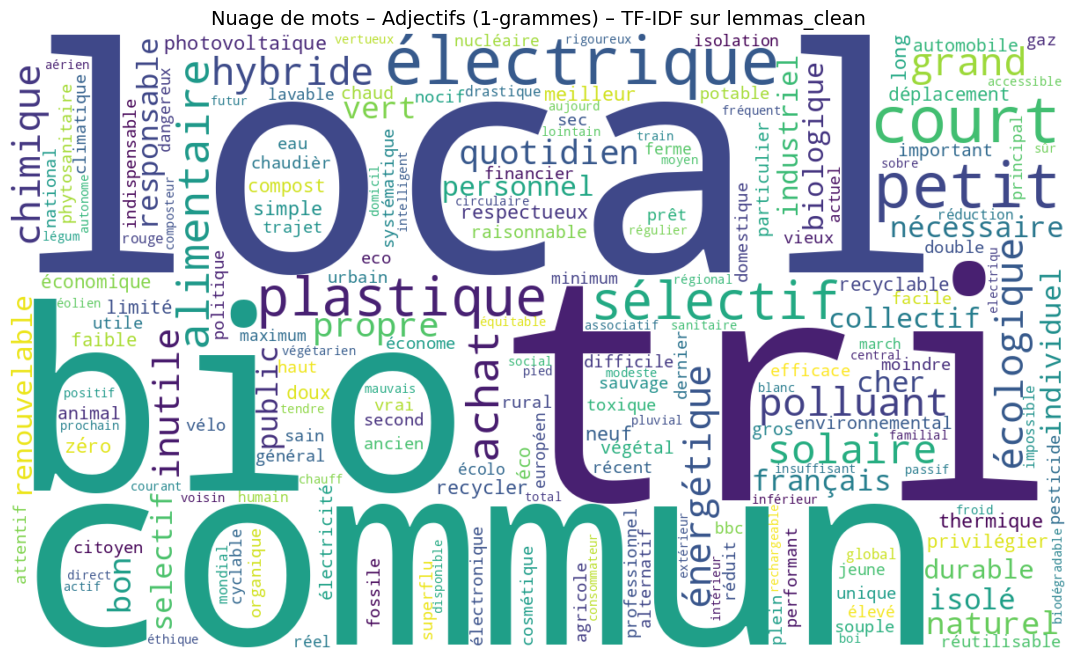

In [ ]:
# 1-grammes adjectifs uniquement (TF-IDF + WordCloud)
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# Corpus
text_col = "lemmas_clean"
corpus = (
    df_lemmas[text_col]
    .fillna("")
    .astype(str)
    .str.strip()
)
corpus = corpus[corpus.str.len() > 0]

# Stopwords: SpaCy FR + ajouts
sw = set(spacy.lang.fr.STOP_WORDS)
sw.update([
    "oui", "si", "etc", "faire", "faut", "être", "etre", "tout", "tous", "plus",
    "moins", "mettre", "aussi", "comme", "mes", "ma", "le", "les", "la", "nos",
    "ses", "des", "de", "il", "ils", "elle", "elles", "pour", "qui", "que", "quoi",
    "quand", "comment", "parce", "avec", "sans", "donc", "car", "cela", "ça", "ca",
    "c'est", "cest", "l'", "l’", "d'", "d’", "j'", "j’", "c'", "c’", "n'", "n’", "t'", "t’",
])
stop_words = sw  # set accepté par nos filtres manuels

# Préprocesseur (apostrophes/espaces)
def preproc(s: str) -> str:
    s = s.replace("’", "'")
    s = re.sub(r"\s+", " ", s)
    return s

# POS tagging et extraction des adjectifs (lemma, minuscules)
nlp = spacy.load("fr_core_news_md", exclude=["ner"])

def doc_to_adjectives(doc):
    return [
        tok.lemma_.lower()
        for tok in doc
        if tok.pos_ == "ADJ"               # seulement adjectifs
        and tok.is_alpha                   # lettres uniquement
        and len(tok) > 1
        and tok.lemma_.lower() not in stop_words
    ]

adj_texts = []
for doc in nlp.pipe((preproc(t) for t in corpus.values), batch_size=1000, n_process=1):
    adjs = doc_to_adjectives(doc)
    adj_texts.append(" ".join(adjs))

# Filtrer les documents vides (sans adjectifs)
adj_series = pd.Series(adj_texts)
adj_series = adj_series[adj_series.str.len() > 0]

# 5) TF‑IDF 1‑grammes sur adjectifs uniquement
vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 1),        # unigrams
    lowercase=False,           # déjà en minuscules
    token_pattern=r"(?u)\b[\w'-]{2,}\b",
    min_df=5,
    max_features=10000,
)
X = vectorizer.fit_transform(adj_series.values)
terms = vectorizer.get_feature_names_out()
scores = np.asarray(X.sum(axis=0)).ravel()

# Top-N pour le WordCloud
TOP_N = 500
top_idx = np.argsort(scores)[::-1][:TOP_N]
freqs_top = {terms[i]: float(scores[i]) for i in top_idx}

# WordCloud
wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    prefer_horizontal=0.9,
    collocations=False,
    normalize_plurals=False,
    random_state=42,
)
wc = wc.generate_from_frequencies(freqs_top)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots – Adjectifs (1‑grammes) – TF‑IDF sur lemmas_clean", fontsize=14)
plt.show()

Le wordcloud des adjectifs (unigrammes, TF-IDF) révèle un cadrage fortement normatif et prescriptif des réponses. D’un côté, des qualificatifs valorisants structurent les préférences : *local*, *bio*, *commun/collectif*, *écologique*, *durable*, *renouvelable*. Ils soulignent un imaginaire de proximité, de naturalité, de qualité alimentaire, et d’alternatives technologiques propres. De l’autre, des adjectifs connotés négativement (*plastique*, *polluant*, *chimique*, *inutile*) désignent les cibles à éviter.  

# Wordcould sur les verbes (unigrammes, TF-IDF)


Poursuivons en filtrant les unigrammes uniquement sur les verbes (nous excluons les auxiliaires)

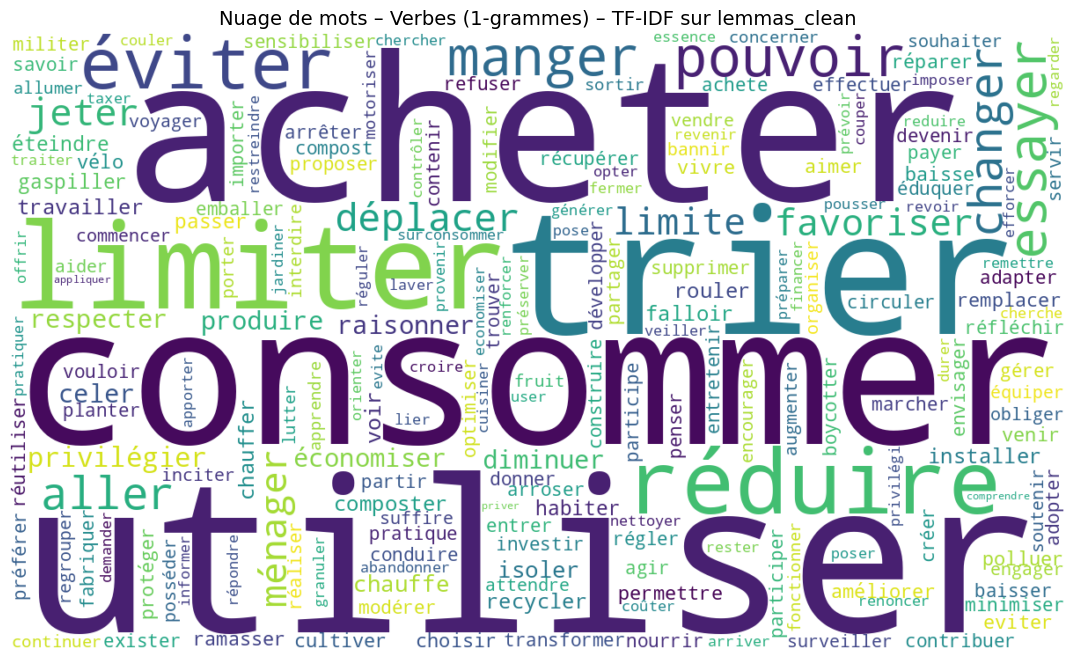

In [ ]:
# 1-grammes verbes uniquement (TF-IDF + WordCloud)

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# Paramètres
text_col = "lemmas_clean"
INCLUDE_AUX = False  # exclure les auxiliaires 

# 1) Corpus
corpus = (
    df_lemmas[text_col]
    .fillna("")
    .astype(str)
    .str.strip()
)
corpus = corpus[corpus.str.len() > 0]

# Stopwords: SpaCy FR + ajouts
sw = set(spacy.lang.fr.STOP_WORDS)
sw.update([
    "oui", "si", "etc", "faire", "faut", "être", "etre", "tout", "tous", "plus",
    "moins", "mettre", "aussi", "comme", "mes", "ma", "le", "les", "la", "nos",
    "ses", "des", "de", "il", "ils", "elle", "elles", "pour", "qui", "que", "quoi",
    "quand", "comment", "parce", "avec", "sans", "donc", "car", "cela", "ça", "ca",
    "c'est", "cest", "l'", "l’", "d'", "d’", "j'", "j’", "c'", "c’", "n'", "n’", "t'", "t’",
    "sélectif", "tri", "donne", "veille", "transport", "laisse", "roule", "faire", "prendre", "devoir", "pler", "fabrique", " achete", "marche", "porte", "issu", "lutte"])
stop_words = sw

# Préprocesseur (apostrophes/espaces)
def preproc(s: str) -> str:
    s = s.replace("’", "'")
    s = re.sub(r"\s+", " ", s)
    return s

# POS-tagging et extraction des verbes 
nlp = spacy.load("fr_core_news_md", exclude=["ner"])
keep_pos = {"VERB"} if not INCLUDE_AUX else {"VERB", "AUX"}

def doc_to_verbs(doc):
    return [
        tok.lemma_.lower()
        for tok in doc
        if tok.pos_ in keep_pos
        and tok.is_alpha
        and len(tok) > 1
        and tok.lemma_.lower() not in stop_words
    ]

verb_texts = []
for doc in nlp.pipe((preproc(t) for t in corpus.values), batch_size=1000, n_process=1):
    verbs = doc_to_verbs(doc)
    verb_texts.append(" ".join(verbs))

# Filtrer les documents vides (sans verbes retenus)
verb_series = pd.Series(verb_texts)
verb_series = verb_series[verb_series.str.len() > 0]

# TF‑IDF 1‑grammes sur verbes
vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 1),        # unigrams
    lowercase=False,           
    token_pattern=r"(?u)\b[\w'-]{2,}\b",
    min_df=5,
    max_features=10000,
)
X = vectorizer.fit_transform(verb_series.values)
terms = vectorizer.get_feature_names_out()
scores = np.asarray(X.sum(axis=0)).ravel()

# Top-N pour le WordCloud
TOP_N = 500
top_idx = np.argsort(scores)[::-1][:TOP_N]
freqs_top = {terms[i]: float(scores[i]) for i in top_idx}

# WordCloud
wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    prefer_horizontal=0.9,
    collocations=False,
    normalize_plurals=False,
    random_state=42,
)
wc = wc.generate_from_frequencies(freqs_top)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots – Verbes (1‑grammes) – TF‑IDF sur lemmas_clean", fontsize=14)
plt.show()

Le *wordcloud* des verbes met en lumière un répertoire d’actions concrètes centrées sur des pratiques individuelles et collectives pour la transition écologique. Dominé par des verbes d’engagement quotidien, il reflète un imaginaire de responsabilité active : *réduire*, *utiliser*, *limiter*, *consommer*, *trier*, *recycler* et *éviter*, lequels soulignent des gestes de sobriété et évoquent une éthique de modération, souvent associée à des objets implicites comme l’énergie ou les plastiques.
  
D’autres verbes orientent vers des transformations positives et les choix alternatifs : *favoriser*, *développer*, *changer*, *installer*, *acheter* et *produire*.
  
Enfin, des verbes plus généraux comme *faire*, *pouvoir* et *avoir* traduisent des marqueurs de faisabilité ou de contrainte, arbitrant entre volonté et obligation.

# Intégration de données géographiqes au dataframe principal

Nous procédons à l'intégration de données géographiques afin d'enrichir notre jeu de données principal. Cette étape, réalisée avant de nous lancer dans le topic modeling, nous permet d'associer à chaque document le statut de la commune correspondante (représenté par la variable **STATUT_COM_UU**)

À partir des fichier récupérés sur le site de l'INSEE, nous intégrons les informations concernant le statut des communes à notre dataframe principal.

Nous utilisons le code postal (col *authorZipCode*) de nos données comme base pour l'association avec les données de l'INSEE. Notons que le code postal n'est pas un identifiant unique de commune, mais il permet une association raisonnable dans la majorité des cas (plusieurs communes peuvent partager un même code postal, seul le code INSEE est propre à chaque commune).

Les informations récupérées sont la population et le statut des communes (B, H, C, I).  

Statut de la commune (extrait du site de l'INSEE): Ce code est calculé en fonction de la population au recensement 2017.
H - Hors unité urbaine
C - Ville-centre
B - Banlieue
I - Ville isolée

Ville isolée : Lorsqu’une unité urbaine est constituée d’une seule commune, on la désigne sous le terme de ville isolée.  
Ville-centre et Banlieue : lorsqu’une unité urbaine est constituée de plusieurs communes, on la désigne sous le terme d’agglomération multicommunale. Les communes qui la composent sont soit ville-centre, soit banlieue.    
Si une commune représente plus de 50 % de la population de l'agglomération multicommunale, elle est seule ville-centre. Sinon, toutes les communes qui ont une population supérieure à 50 % de celle de la commune la plus peuplée, ainsi que cette dernière, sont villes-centres. Les communes urbaines qui ne sont pas villes-centres constituent la banlieue de l'agglomération multicommunale.  
Remarque : une agglomération multicommunale peut n’être constituée que de villes-centres.


Nous pouvons reformuler ainsi les catégories de statut de commune :

**Villes-centres (C)**  
Cœur des grandes agglomérations (ex : Paris, Lyon, Bordeaux).  
Enjeu pour le Grand Débat : Ces communes concentrent souvent des préoccupations liées à la densité, aux transports collectifs ou à la pollution urbaine.  

**Banlieues (B)**  
Communes urbaines intégrées à une agglomération multicommunale, mais qui ne sont pas villes-centres.  
Exemples : Saint-Denis, Vénissieux.    
Enjeu pour le Grand Débat : Problématiques souvent liées à l’étalement urbain, à l’accès aux services ou aux déserts commerciaux en périphérie.  

**Villes isolées (I)**  
Communes urbaines qui forment à elles seules une unité urbaine (pas de continuité de bâti avec d’autres communes).  
Exemples : Albi, Tarbes, ou des villes moyennes en zone rurale.  
Enjeu pour le Grand Débat : Elles cumulent des défis à la fois urbains (services, mobilités) et ruraux (isolement relatif, desserte limitée).  

**Hors unité urbaine (H)**  
Communes rurales ou périurbaines lointaines, sans lien de continuité avec une agglomération.  
Exemples : Villages de moins de 2 000 habitants, bourgs éloignés des pôles urbains.  
Enjeu pour le Grand Débat : Accès aux services publics, mobilités contraintes (voiture individuelle dominante), ou transition énergétique (chauffage au bois, rénovation des logements anciens).  

In [ ]:
## Intégration des données INSEE

import pandas as pd

# import corres
corres = pd.read_csv('data/correspondance.csv', sep=';')

corres_INSEE_zip = corres[['Code INSEE', 'Code Postal', 'Population']].copy()

corres_INSEE_zip = corres_INSEE_zip.rename(
    columns={
        'Code INSEE': 'code_INSEE',
        'Code Postal': 'code_zip'
    }
)
corres_INSEE_zip_filtered = corres_INSEE_zip 


import pandas as pd
# import cog_uu
cog_uu = pd.read_csv('data/COG_UU.csv', sep=';')

# Renommer la colonne CODGEO dans cog_uu
cog_uu = cog_uu.rename(columns={'CODGEO': 'code_INSEE'})

# merge de corres_INSEE_zip et cog_uu
cog = pd.merge(
    corres_INSEE_zip_filtered,  # ton premier DataFrame
    cog_uu,            # ton second DataFrame
    on='code_INSEE',   # colonne de jointure
    how='left'        # choisis 'inner' ou 'left' selon ce que tu veux (je recommande 'inner' si tu veux garder uniquement les correspondances exactes)
)

# supprimer la colonne code_INSEE
cog = cog.drop(columns=['code_INSEE'])

# Ajouter les zéros manquants au début dans df_lemmas
import pandas as pd

# Si le CSV est déjà importé
df_lemmas['authorZipCode'] = (
    df_lemmas['authorZipCode']
    .astype(str)  # Conversion en string
    .str.zfill(5)  # Remplissage avec des zéros à gauche
)

# renommer la colonne authorZipCode en code_zip
df_lemmas = df_lemmas.rename(columns={'authorZipCode': 'code_zip'})

# crée une version "explosée" du dataframe cog
cog_exploded = (
    cog.assign(code_zip=cog['code_zip'].str.split('/'))
    .explode('code_zip')
    .drop_duplicates(subset='code_zip')  # au cas où il y aurait des doublons
)

# jointure
df_lemmas_cog = df_lemmas.merge(
    cog_exploded[['code_zip', 'STATUT_COM_UU', 'Population']], 
    on='code_zip', 
    how='left'
)

paris = [
    '75001','75002','75003','75004','75005','75006','75007','75008','75009','75010',
    '75011','75012','75013','75014','75015','75016','75017','75018','75019','75020'
]

lyon = ['69001','69002','69003','69004','69005','69006','69007','69008','69009']

marseille = [
    '13001','13002','13003','13004','13005','13006','13007','13008',
    '13009','13010','13011','13012','13013','13014','13015','13016'
]

# liste concaténée
arrondissements = paris + lyon + marseille

# Convertir la liste en set pour accélérer isin
arr_set = set(arrondissements)

# Affecter 'C' aux lignes correspondant aux arrondissements
mask_arr = df_lemmas_cog["code_zip"].isin(arr_set)
df_lemmas_cog.loc[mask_arr, "STATUT_COM_UU"] = "C"

# ne pas écraser les valeurs manquantes:
na_mask = df_lemmas_cog["STATUT_COM_UU"].isna()
df_lemmas_cog.loc[mask_arr & na_mask, "STATUT_COM_UU"] = "C"

# (Option) Si STATUT_COM_UU est catégorielle, s’assurer que 'C' est une modalité
if pd.api.types.is_categorical_dtype(df_lemmas_cog["STATUT_COM_UU"]):
    if "C" not in df_lemmas_cog["STATUT_COM_UU"].cat.categories:
        df_lemmas_cog["STATUT_COM_UU"] = df_lemmas_cog["STATUT_COM_UU"].cat.add_categories(["C"])

# création de df_lemmas_cog à partir de df_lemmas_cog en imputant catégorie aux aux grandes villes
df_lemmas_cog = (
    df_lemmas_cog
    .dropna(subset=["lemmas_clean"])
    .reset_index(drop=True)
)

# élimination aussi les chaînes vides ou seulement avec des espaces !
df_lemmas_cog_wnan = df_lemmas_cog_wnan[df_lemmas_cog_wnan["lemmas_clean"].str.strip() != ""].reset_index(drop=True)

df_lemmas_cog_wnan = (
    df_lemmas_cog_wnan
    .dropna(subset=["STATUT_COM_UU"])
    .reset_index(drop=True)
)

# Nombre de lignes initial
nb_lignes_initial = len(df_lemmas)

# Nombre de lignes après nettoyage
nb_lignes_apres_nettoyage = len(df_lemmas_cog_wnan)

# Calcul du nombre de lignes éliminées
nb_lignes_eliminees = nb_lignes_initial - nb_lignes_apres_nettoyage

print(f"Nombre de lignes initial : {nb_lignes_initial}")
print(f"Nombre de lignes après nettoyage : {nb_lignes_apres_nettoyage}")
print(f"Nombre de lignes éliminées : {nb_lignes_eliminees}")


# Sauvegade du dataframe
df_lemmas_cog_wnan.to_csv("df_lemmas_cog_wnan.csv", index=False)

Nombre de lignes initial : 87562
Nombre de lignes après nettoyage : 71499
Nombre de lignes éliminées : 16063


Nous avons éliminé les docs non renseignés sur le statut de la commune. Il reste **71499** docs.

## Statistiques sur les statuts des communes du corpus (colonne : STATUT_COM_UU)

  STATUT_COM_UU_std  nb_docs    pct_docs
0                 B    27189   38.027105
1                 C    20534   28.719283
2                 H    19847   27.758430
3                 I     3929    5.495182
4             Total    71499  100.000000


/tmp/ipykernel_1621/3977083857.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_1621/3977083857.py:59: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(


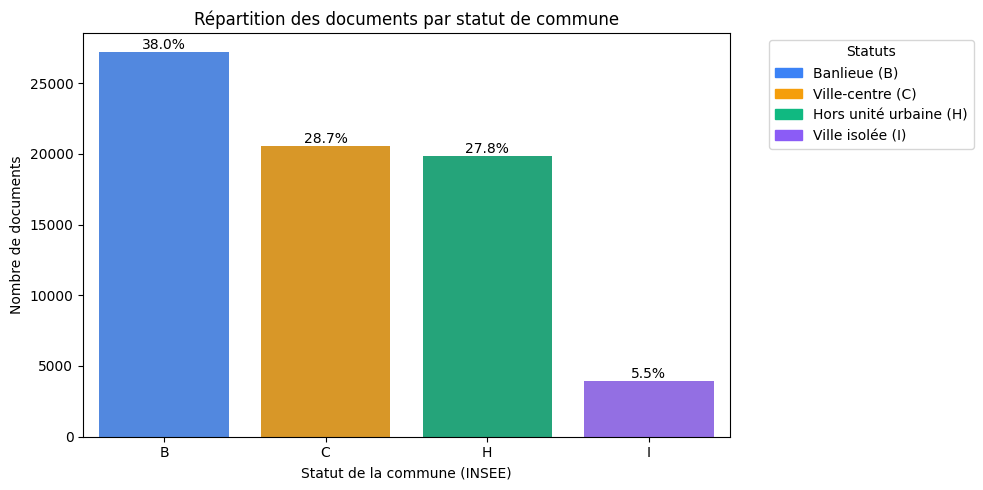

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copie de travail 
df = df_lemmas_cog_wnan.copy()

# Standardisation de STATUT_COM_UU et création d'une modalité 'nan'
statut = df["STATUT_COM_UU"].astype("string")
statut = statut.replace({"NaN": pd.NA, "nan": pd.NA, "": pd.NA})
statut = statut.fillna("nan")

# Ordre des modalités
categories = pd.CategoricalDtype(
    categories=["B", "C", "H", "I", "nan"],
    ordered=True
)
df["STATUT_COM_UU_std"] = statut.astype(categories)

# Agrégation: comptage du nombre de documents par statut
docs_by_statut = (
    df.groupby("STATUT_COM_UU_std", dropna=False, observed=True)
      .size()
      .rename("nb_docs")
      .reset_index()
)

# Calcul pourcentages
total_docs = docs_by_statut["nb_docs"].sum()
docs_by_statut["pct_docs"] = np.where(
    total_docs > 0,
    (docs_by_statut["nb_docs"] / total_docs) * 100,
    np.nan
)

# Tri selon ordre des catégories
docs_by_statut = docs_by_statut.sort_values(
    by="STATUT_COM_UU_std",
    key=lambda s: s.cat.codes
)

# Ajout d'une ligne Total
total_row = pd.DataFrame({
    "STATUT_COM_UU_std": ["Total"],
    "nb_docs": [total_docs],
    "pct_docs": [100.0]
})
docs_by_statut = pd.concat([docs_by_statut, total_row], ignore_index=True)

# Affichage tableau
print(docs_by_statut)

# Visualisation 
plot_data = docs_by_statut[docs_by_statut["STATUT_COM_UU_std"] != "Total"]

plt.figure(figsize=(10, 5))
palette = ["#3b82f6", "#f59e0b", "#10b981", "#8b5cf6", "#6b7280"]
ax = sns.barplot(
    data=plot_data,
    x="STATUT_COM_UU_std",
    y="nb_docs",
    palette=palette
)

# Étiquettes et titre
plt.xlabel("Statut de la commune (INSEE)")
plt.ylabel("Nombre de documents")
plt.title("Répartition des documents par statut de commune")

# Étiquettes pourcentage au-dessus des barres
for i, row in plot_data.iterrows():
    plt.text(
        i,
        row["nb_docs"],
        f"{row['pct_docs']:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Légende 
handles = [
    plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(plot_data))
]
labels = [
    "Banlieue (B)",
    "Ville-centre (C)",
    "Hors unité urbaine (H)",
    "Ville isolée (I)",
    "Non renseigné (nan)"
]
plt.legend(handles, labels, title="Statuts", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


La répartition met en évidence une surreprésentation des contributions issues du périurbain/banlieue (B, 38,0 %) et, dans une moindre mesure, des ville-centres (C, 28,7 %). À l’inverse, les espaces ruraux sont moins présents dans le corpus.  
Cette structure suggère un biais urbain/périurbain de la participation, le milieu rural ayant moins contribué.

# Topic modeling

Importons le modèle **CammenBert**.

In [ ]:
# Importer cammembert
from sentence_transformers import SentenceTransformer

# Téléchargement 
print("⚙️ Téléchargement du modèle CamemBERT-large...")
embedding_model = SentenceTransformer(
    "dangvantuan/sentence-camembert-base",
    device="cpu",
    cache_folder="./models"  # Sauvegarde locale 
)
print("✅ Modèle prêt !")

/home/algernon/projets/Case_Study/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚙️ Téléchargement du modèle CamemBERT-large...
✅ Modèle prêt !


Nous importons BERTopic qui est une méthode de modélisation thématique qui combine des embeddings de phrases (transformers) avec une réduction de dimension (UMAP) et un clustering (HDBSCAN) pour découvrir automatiquement des sujets cohérents dans le corpus.  

Nous utilisons cette fois **fr_core_news_lg** au lieu de **fr_core_news_md** pour bénéficier d'un vocabulaire plus riche et de meilleures représentations sémantiques.

In [ ]:
from bertopic import BERTopic
# Import de spaCy long
print("Chargement du modèle spaCy 'fr_core_news_lg'...")
nlp = spacy.load("fr_core_news_lg")
print("Modèle chargé.")

## Création d'un set de stop words

Nous utilisons les stop words français de spaCy par défaut, nous en augmenterons la liste à la demande.

In [ ]:
# Configuration stopwords
from spacy.lang.fr.stop_words import STOP_WORDS
import spacy

# 1. Liste de base SpaCy 
stop_words = set(spacy.lang.fr.STOP_WORDS)  # Convertir en set pour les opérations d'ensemble

# 2. Extension optimisée (éviter les mots déjà présents dans STOP_WORDS)
additional_words = {"oui", "non", "si", "etc", "donc", "car", "faire", "falloir", "pouvoir", "être", "cela", "ça", "chose", "vraiment", "absolument", "aujourd'hui", "quelque", "lorsque", "bah", "ah", "hein"
}
stop_words.update(additional_words)  # set au lieu de liste

# nettoyage NLP français
for word in ["c'est", "qu'il", "lorsqu'"]:
    stop_words.discard(word)  

# Conversion finale en liste (nécessaire pour scikit-learn/CountVectorizer)
stop_words = list(stop_words)

## Étape de segmentation des docs

Nous cherchons dans cette partie à favoriser une modélisation thématique précise en évitant de diluer des thèmes spécifiques dans des textes longs et multifacettes.  

L'analyse suivante se fera donc sur ces segments individuels des documents originaux plutôt que sur chaque document pris comme un ensemble, ce qui présente l'avantage d'une granularité accrue.    
ex. : "je trie mes déchets" et "j'utilise mon vélo" devront être séparés s'ils sont présents au sein d'un même document.

Note : nous devrons, tout au long de notre workflow, conserver une **traçabilité** des segments (en indiquant, par exemple, que tel segment provient de tel document original) afin de pouvoir effectuer des statistiques agrégées sur les segments.  

Dans le script suivant, nous implémentons une étape de segmentation textuelle des réponses ouvertes du dataset, en nous basant sur une approche *rule-based* (fondée sur des règles syntaxiques prédéfinies et des expressions régulières) plutôt que sur un modèle de langage large (LLM) tel que **Flan-T5** ou **Qwen**.  

Cette stratégie **rule-based** offre un contrôle fin sur le processus, une reproductibilité accrue et une efficacité computationnelle sans dépendre de ressources externes ou de modèles pré-entraînés complexes, tout en permettant d'ajuster manuellement les règles pour s'adapter au style informel et varié des réponses du Grand Débat National.  

Cependant, la création de segments propres s'avère complexe en raison de la variabilité syntaxique des réponses (phrases incomplètes, listes informelles sans ponctuation, ou enchaînements sans marqueurs clairs), et nous évaluons l'efficacité des règles en testant sur une liste d'exemples représentatifs pour raffiner itérativement le processus.  

Une fois appliquée aux documents originaux, cette segmentation augmentera significativement le nombre de documents à analyser (en transformant chaque réponse en plusieurs segments).  

Concrètement, le code utilise le modèle SpaCy **fr_core_news_lg** pour la segmentation en phrases, active le composant **sentencizer**, et définit deux fonctions :   
D'abord **normalize** pour une normalisation légère du texte (gestion des espaces, apostrophes et contractions courantes en français).  
Puis **segmenter_spacy** pour le pré-traitement regex (remplacement de virgules par des points, insertion de points avant des marqueurs d'actions ou de pronoms sujets comme "je" ou "et" pour favoriser des splits sémantiques pertinents).   
Suivi de l'application de SpaCy pour extraire les phrases, nettoyer les débuts inutiles (ex. : suppression de "Et" isolé) et normaliser la sortie en minuscules avec des points finaux.  
   

In [ ]:
import re
import spacy

# Chargement du modèle SpaCy 
nlp = spacy.load("fr_core_news_lg")
nlp.add_pipe("sentencizer")  # Active la segmentation en phrases

def normalize(text: str) -> str:
    """Fonction de normalisation"""
    text = (text or "").strip()
    if not text:
        return text
    text = re.sub(r"\s+", " ", text)  # Normalise les espaces
    text = text.replace("’", "'")     # Gère les apostrophes
    text = re.sub(r"\s*,\s*", ", ", text)
    text = re.sub(r"\s*'\s*", "'", text)  # Pas d'espace autour des apostrophes (ex. "de l eau" -> "de l'eau")
    text = re.sub(r"\b([Dd]e|[ÀàAa])\s+l\s+([aeiouhAEIOUHéèêàùûîô])", r"\1 l'\2", text)
    text = re.sub(r"\b([JjLlDdCcNnQqTtMmSs])'\s+([A-Za-zéèêàùûîôç])", r"\1'\2", text)
    return text

def segmenter_spacy(txt: str) -> str:
    """Fonction de segmentation : pré-traitement regex + SpaCy sentencizer."""
    # Normalisation initiale
    txt = normalize(txt)
    
    # Pré-traitement : remplace virgules par points pour préparer segmentation en phrases
    txt = re.sub(r',', '.', txt)
    
    # Insertion de points avant "et" suivi d'un pronom sujet 
    pron_subj = r'(je|j\'|nous|on|il|elle|ils|elles|vous|tu)'
    txt = re.sub(r'\set\s+' + pron_subj, r'. Et \1', txt, flags=re.IGNORECASE)
    
    # Insertion de points avant mots-clés d'actions 
    patterns = r'\s+(tri|économie|chau(ffage)?|amélioration|changement|je|j\')(?=\s+[a-z])'
    txt = re.sub(patterns, r'. \1', txt, flags=re.IGNORECASE)
    
    # Applique SpaCy pour segmenter en phrases
    doc = nlp(txt)
    
    # Construit la sortie : ajoute un point si nécessaire, supprime "Et" en début
    sentences = []
    for sent in doc.sents:
        sent_text = sent.text.strip()
        if sent_text:
            # Supprime "Et " ou "et " en tout début de phrase
            sent_text = re.sub(r'^Et\s+', '', sent_text, flags=re.IGNORECASE)
            sent_text = re.sub(r'^et\s+', '', sent_text, flags=re.IGNORECASE)       # Ajouter point seulement si pas déjà présent (évite doubles points)
            if not re.search(r'[.!?]$', sent_text):
                sent_text += '.'
            sentences.append(sent_text)
    
    # joint les phrases avec un espace, normalise les doubles points/espace
    output = ' '.join(sentences)
    output = re.sub(r'\.{2,}', '.', output)  # Supprime doubles points résiduels
    output = re.sub(r'\s+', ' ', output).strip()
    # Tout en minuscules 
    output = output.lower()
    return output

    # exemples tests
examples = [
    "je trie mes déchets, je fais du compost, j'utilise mon vélo",
    "maison bbc chauffage au bois économie de l eau tri sélectif",
    "je prends les transports en commun et j'évite la voiture et j'achète local",
    "amélioration de l'isolation de mon domicile changement de la chaudière à gaz vers une chaudière à condensation à gaz je fais aussi attention à ma consommation d'eau",
    "Eco conduite, utilisation de l'eau de pluie pour le jardinage, mise en place de ruches pour lutter contre la disparition des abeilles, réduire le chauffage, passer d'une cheminée à un poêle à granulés, ...",
    "tri des déchets,  suppression des pesticides et autres produits chimiques",
    "Limiter les déplacements en voiture et favoriser si possible les transports en communs",
    "Moi non, les transporteurs routiers et maritimes, les agriculteurs, les industriels, les compagnies aériennes, le monde du bâtiment: oui. Mais on ne leur demande rien à eux. Pourquoi ?",
    "économie d énergie",
    "Je ne consomme plus de viande, je limite mes déchets et je consomme local. Professionnelle de santé exerçant aux domiciles de mes patients, il m'est difficile de réduire mon impact carburant. Mais, si l'on me donne les moyens d'avoir un véhicule moins polluant (ceux-ci sont actuellement hors de prix malgré les aides), je le ferai volontiers!",
    "Mon jardin est cultivé en permaculture.  pesticide, insecticide, fongicide, etc",
    "Photovoltaïque, tri sélectif, voitures avec filtres à particule",
    "Je n'utilise ma voiture, récemment renouvelée, que parcimonieusement (pour les trajets les plus longs,) sinon c'est marche, vélo ou transports en commun. Je trie mes déchets avec un compost dans le jardin. Ma maison est isolée correctement. Je prends des douches. J'essaie de réduire la consommation de viande. Je ne prends qu'exceptionnellement l'avion. J'évite toute consommation énergétique superflue (objets jetables à usage unique, veille des appareils électriques, éclairages divers...)"
]

# Test et affichage des résultats
for i, txt in enumerate(examples, 1):
    print(f"--- Exemple {i} ---")
    print("Entrée :", txt)
    print("Sortie :", segmenter_spacy(txt))


--- Exemple 1 ---
Entrée : je trie mes déchets, je fais du compost, j'utilise mon vélo
Sortie : je trie mes déchets. je fais du compost. j'utilise mon vélo.
--- Exemple 2 ---
Entrée : maison bbc chauffage au bois économie de l eau tri sélectif
Sortie : maison bbc. chauffage au bois. économie de l'eau. tri sélectif.
--- Exemple 3 ---
Entrée : je prends les transports en commun et j'évite la voiture et j'achète local
Sortie : je prends les transports en commun. j'évite la voiture. j'achète local.
--- Exemple 4 ---
Entrée : amélioration de l'isolation de mon domicile changement de la chaudière à gaz vers une chaudière à condensation à gaz je fais aussi attention à ma consommation d'eau
Sortie : amélioration de l'isolation de mon domicile. changement de la chaudière à gaz vers une chaudière à condensation à gaz. je fais aussi attention à ma consommation d'eau.
--- Exemple 5 ---
Entrée : Eco conduite, utilisation de l'eau de pluie pour le jardinage, mise en place de ruches pour lutter contr

Le résultat sur les exemples est satisfaisant mais nécessitera un prétraitement supplémentaire pour éliminer les segments trop courts ou non informatifs.

Code pour appliquer le pipeline de segmentation sur l'ensemble du corpus :  
(Note : le même code a été exécuté sur Kaggle pour profiter de la rapidité des GPU mis à disposition.)

In [ ]:
# Application du pipeline de segmentation à l'ensemble du corpus
### Non exécuter en local (Kaggle) ###
import tqdm
import pandas as pd  

col = "QUXVlc3Rpb246MTQ5 - Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?"

# Création nouveau DataFrame en copiant original pour conserver l'index
df_lemmas_cog_wnan_seg = df_lemmas_cog_wnan.copy()

# Fonction wrapper pour gérer les NaN/vides
def apply_segmentation(txt):
    if pd.isna(txt) or not txt.strip():
        return ""
    return segmenter_spacy(txt)

# Application avec barre de progression manuelle
results = []
for txt in tqdm.tqdm(df_lemmas_cog_wnan_seg[col], total=len(df_lemmas_cog_wnan_seg_lem), desc="Segmentation en cours"):
    results.append(apply_segmentation(txt))

# Ajout de la nouvelle colonne 'seg'
df_lemmas_cog_wnan_seg['seg'] = results

Importons le dataframe *df_lemmas_cog_wnan_seg* issu du calcule effectué sur Kaggle.

In [ ]:
# Import df_seg
import pandas as pd

output_path_pickle = "output/df_lemmas_cog_wnan_seg.pkl"

print("\nChargement du DataFrame depuis le fichier Pickle...")
df_lemmas_cog_wnan_seg = pd.read_pickle(output_path_pickle)
print("Chargement terminé.")


Chargement du DataFrame depuis le fichier Pickle...
Chargement terminé.


In [ ]:
# test du modèle de segmentation sur un échantillon de docs du corpus
import numpy as np
import random
import pandas as pd
col = "QUXVlc3Rpb246MTQ5 - Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?"

# Pour l'affichage
pd.set_option('display.max_colwidth', None)

# Graine 
SEED = 18
np.random.seed(SEED)   
random.seed(SEED)      

# Échantillonnage 
random_sample = (
    df_lemmas_cog_wnan_seg[[col, 'seg']]
    .sample(n=4, random_state=SEED)  # <- graine ici
)

# Affichage
for idx, row in random_sample.iterrows():
    print(f"Ligne {idx}:")
    print(row[col])
    print(row['seg'])
    print("-" * 80)

Ligne 24553:
Utiliser des emballages non polluants
utiliser des emballages non polluants.
--------------------------------------------------------------------------------
Ligne 6193:
Voiture de dernière génération, chauffage écologique, tri des déchets, compostage
voiture de dernière génération. chauffage écologique. tri des déchets. compostage.
--------------------------------------------------------------------------------
Ligne 15990:
Manger local et / ou bio.  Moins consommer de manière générale (vêtements, énergie, technologies )
manger local et / ou bio. moins consommer de manière générale (vêtements. énergie. technologies ).
--------------------------------------------------------------------------------
Ligne 61505:
je pense faire de mon mieux pour ne rien gaspiller
je pense faire de mon mieux pour ne rien gaspiller.
--------------------------------------------------------------------------------


Nous devons éliminer la ponctuation inutile (en conservant les points qui séparent les segments).

In [ ]:
# Colonne lemmas_seg -> lemmas_seg_clean
df_lemmas_cog_wnan_seg["seg_ponc"] = df_lemmas_cog_wnan_seg["seg"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

import re

# Supprime la ponctuation résiduelle (tout sauf lettres, chiffres et espaces)
df_lemmas_cog_wnan_seg["seg_ponc"] = (
    df_lemmas_cog_wnan_seg["seg_ponc"]
    .str.lower()
    .str.replace(r"[^\w\s\.]", " ", regex=True)   
    .str.replace(r"\s+", " ", regex=True)       # remplace plusieurs espaces par un seul
    .str.strip()
)

# Pour l'affichage
pd.set_option('display.max_colwidth', None)

SEED = 18
np.random.seed(SEED)   
random.seed(SEED)      

# Échantillonnage 
random_sample = (
    df_lemmas_cog_wnan_seg[['seg', 'seg_ponc']]
    .sample(n=4, random_state=SEED)  
)

# Affichage
for idx, row in random_sample.iterrows():
    print(f"Ligne {idx}:")
    print(row['seg'])
    print(row['seg_ponc'])
    print("-" * 80)

Ligne 24553:
utiliser des emballages non polluants.
utiliser des emballages non polluants.
--------------------------------------------------------------------------------
Ligne 6193:
voiture de dernière génération. chauffage écologique. tri des déchets. compostage.
voiture de dernière génération. chauffage écologique. tri des déchets. compostage.
--------------------------------------------------------------------------------
Ligne 15990:
manger local et / ou bio. moins consommer de manière générale (vêtements. énergie. technologies ).
manger local et ou bio. moins consommer de manière générale vêtements. énergie. technologies .
--------------------------------------------------------------------------------
Ligne 61505:
je pense faire de mon mieux pour ne rien gaspiller.
je pense faire de mon mieux pour ne rien gaspiller.
--------------------------------------------------------------------------------


## Étape de lemmatisation des documents segmentés

Cette étape est également exécutée sur Kaggle.

In [ ]:
# Lemmatisation 
import spacy
from tqdm import tqdm
import pandas as pd
import re  

col_seg = "seg_ponc"

# Charger le modèle spaCy français
nlp = spacy.load("fr_core_news_lg")

# Fonction de lemmatisation 
def spacy_lemmatizer(text):
    if not text or pd.isna(text):  
        return ""
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.is_punct and token.text != '.':  # Ignore ponctuation sauf points
            continue
        lemmas.append(token.lemma_)
    lemmatized_str = ' '.join(lemmas)  # Joint avec espaces
    
    # Post-normalisation : Corrige contractions courantes (ex. : "de le" → "du")
    lemmatized_str = re.sub(r'\bde le\b', 'du', lemmatized_str, flags=re.IGNORECASE)
    lemmatized_str = re.sub(r'\bà le\b', 'au', lemmatized_str, flags=re.IGNORECASE)
    lemmatized_str = re.sub(r'\bà les\b', 'aux', lemmatized_str, flags=re.IGNORECASE)
        
    # Nettoyage final : Supprime espaces multiples, strip, et évite points isolés
    lemmatized_str = re.sub(r'\s+', ' ', lemmatized_str).strip()
    lemmatized_str = re.sub(r'\s*\.\s*', ' . ', lemmatized_str)  
    lemmatized_str = re.sub(r'\.{2,}', '.', lemmatized_str)  
    return lemmatized_str.lower()  

# Ajouter la colonne "lemmas_seg" 
tqdm.pandas()  
df_lemmas_cog_wnan_seg['lemmas_seg'] = df_lemmas_cog_wnan_seg[col_seg].fillna('').progress_apply(spacy_lemmatizer)
df_lemmas_cog_wnan_seg_lem = df_lemmas_cog_wnan_seg.copy()

Chargement du dataframe *df_lemmas_cog_wnan_seg_lem*, résultat du code précésent issu du calcul effectué sur Kaggle.

In [ ]:
# Import résultat Kaggle
import pandas as pd

output_path_pickle = "output/df_lemmas_cog_wnan_seg_lem.pkl"

print("\nChargement du DataFrame depuis le fichier Pickle...")
df_lemmas_cog_wnan_seg_lem = pd.read_pickle(output_path_pickle)
print("Chargement terminé.")


Chargement du DataFrame depuis le fichier Pickle...
Chargement terminé.


In [ ]:
# Affichage après lemmatisation 
import numpy as np
import random
import pandas as pd

pd.set_option('display.max_colwidth', None)

SEED = 18
np.random.seed(SEED)  
random.seed(SEED)      

# Échantillonnage 
random_sample = (
    df_lemmas_cog_wnan_seg_lem[['seg_ponc', 'lemmas_seg']]
    .sample(n=4, random_state=SEED)  # <- graine ici
)

# Affichage
for idx, row in random_sample.iterrows():
    print(f"Ligne {idx}:")
    print(row['seg_ponc'])
    print(row['lemmas_seg'])
    print("-" * 80)

Ligne 24553:
utiliser des emballages non polluants.
utiliser un emballage non polluant . 
--------------------------------------------------------------------------------
Ligne 6193:
voiture de dernière génération. chauffage écologique. tri des déchets. compostage.
voiture de dernier génération . chauffage écologique . tri de déchet . compostage . 
--------------------------------------------------------------------------------
Ligne 15990:
manger local et ou bio. moins consommer de manière générale vêtements. énergie. technologies .
manger local et ou bio . moins consommer de manière général vêtement . énergie . technologie . 
--------------------------------------------------------------------------------
Ligne 61505:
je pense faire de mon mieux pour ne rien gaspiller.
je penser faire de mon mieux pour ne rien gaspiller . 
--------------------------------------------------------------------------------


## Étape de séparation des segments

In [ ]:
import pandas as pd
import re
from tqdm import tqdm

# Vérif index (pour traçabilité) 
if 'original_index' not in df_lemmas_cog_wnan_seg_lem.columns:
    df_lemmas_cog_wnan_seg_lem = df_lemmas_cog_wnan_seg_lem.reset_index().rename(columns={'index': 'original_index'})

# Fonction pour splitter une string en liste de segments clean
def split_segments(text):
    if not text or pd.isna(text):
        return []           # Retourne liste vide pour les cas vides
    segments = re.split(r'\s*\.\s*', text)
    # Clean : strip, supprime vides
    segments = [seg.strip() for seg in segments if seg.strip()]
    return segments

# Ajouter une colonne temporaire avec la liste des segments
tqdm.pandas()  # Barre progression
df_lemmas_cog_wnan_seg_lem['segments_list'] = df_lemmas_cog_wnan_seg_lem['lemmas_seg'].fillna('').progress_apply(split_segments)

# Exploser le DataFrame : Crée une ligne par segment, en conservant les infos des autres colonnes
df_segments = df_lemmas_cog_wnan_seg_lem.explode('segments_list').reset_index(drop=True)

# Renommer la colonne des segments 
df_segments = df_segments.rename(columns={'segments_list': 'segment'})

# Ajouter le numéro de segment par document original (traçabilité)
df_segments['segment_num'] = df_segments.groupby('original_index').cumcount()

# Supprime les lignes avec segment vide (voir si on garde ???)
df_segments = df_segments[df_segments['segment'].notna() & (df_segments['segment'] != '')]

# Vérification : Afficher des stats
print(f"Nombre de lignes originales : {len(df_lemmas_cog_wnan_seg_lem)}")
print(f"Nombre de lignes après splitting : {len(df_segments)}")

100%|██████████| 71499/71499 [00:00<00:00, 71846.85it/s]


Nombre de lignes originales : 71499
Nombre de lignes après splitting : 337215


Notre nouveau dataframe **df_segments** contient maintenant **337215** documents (segments "explosées" en documents individuels) au lieu de 71499 documents initiaux.   
Vérifions sur un échantillon que la séparation s'est bien déroulée.

In [ ]:
# Affichage de 4 lignes au hasard de la colonne "segment"
sample_df = df_segments.sample(n=4, random_state=11)  

# Afficher seulement la colonne "segment" 
print(sample_df["segment"])  

160072    j agir à mon échelle personnel pour limiter mon impact
280595                                                compostage
289964                               je me déplacer à bicyclette
146553                         je prendre le transport en commun
Name: segment, dtype: object


### Filtrage avant topic modeling

Dans le script suivant, nous procédons à un filtrage qualitatif des segments textuels issus de la segmentation précédente, en excluant les entrées vides ou trop courtes pour ne conserver que celles suffisamment informatives (au moins 3 mots), afin de préparer un corpus optimisé pour l'étape de modélisation thématique avec BERTopic.   
L'ojectif est ici de réduir le bruit potentiel dans les données (comme des fragments inexploitables qui pourraient diluer les thèmes pertinents), en améliorant ainsi la robustesse des analyses ultérieures.

In [ ]:
import pandas as pd  

column_name = "segment"  

# Exclure textes courts 
df_filtered = df_segments.dropna(subset=[column_name]).copy()  # Copie pour ne pas modifier l'original
df_filtered = df_filtered[df_filtered[column_name].apply(lambda x: len(str(x).split()) >= 3)]  # Min 3 mots

# Préparation du corpus pour BERTopic 
filtered_corpus = df_filtered[column_name].tolist()

# traçabilité : indices dans df_filtered 
original_indices = df_filtered.index.tolist()  

# Affichage stats 
print(f"Nombre de segments originaux : {len(df_segments)}")
print(f"Nombre de segments filtrés : {len(df_filtered)}")
print(f"Pourcentage conservé : {len(df_filtered) / len(df_segments) * 100:.2f}%")

Nombre de segments originaux : 337215
Nombre de segments filtrés : 268709
Pourcentage conservé : 79.68%


Environ 80 % des segments sont conservés après filtrage (min 3 mots). Soit **268709** documents, ce qui est amplement suffisant pour du topic modeling robuste.

## Statistiques géographiques sur les segments

  STATUT_COM_UU_std  nb_docs    pct_docs
0                 B   100881   37.542844
1                 C    78176   29.093183
2                 H    75069   27.936913
3                 I    14583    5.427061
4             Total   268709  100.000000


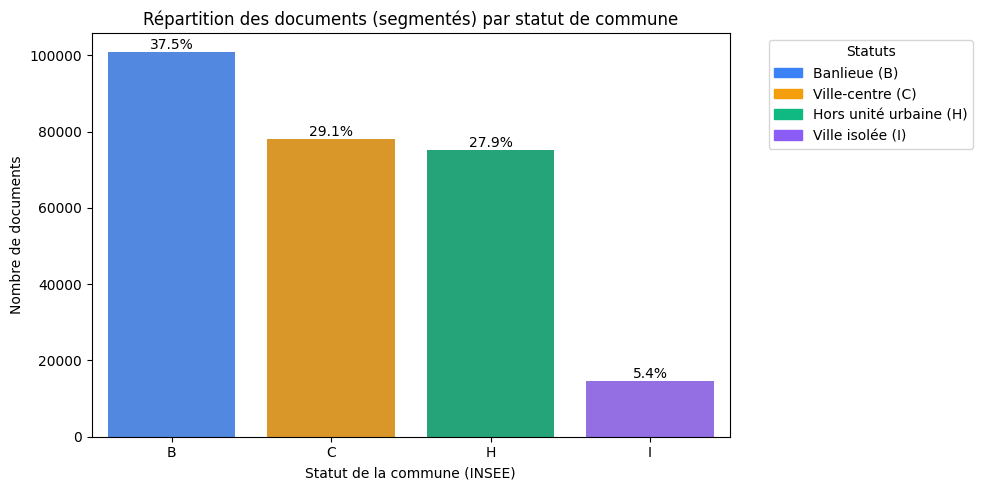

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copie de travail 
df = df_filtered.copy()

# Standardisation de STATUT_COM_UU et création d'une modalité 'nan'
statut = df["STATUT_COM_UU"].astype("string")
statut = statut.replace({"NaN": pd.NA, "nan": pd.NA, "": pd.NA})
statut = statut.fillna("nan")

# Ordre des modalités
categories = pd.CategoricalDtype(
    categories=["B", "C", "H", "I", "nan"],
    ordered=True
)
df["STATUT_COM_UU_std"] = statut.astype(categories)

# Agrégation: comptage du nombre de documents par statut
docs_by_statut = (
    df.groupby("STATUT_COM_UU_std", dropna=False, observed=True)
      .size()
      .rename("nb_docs")
      .reset_index()
)

# Calcul des pourcentages
total_docs = docs_by_statut["nb_docs"].sum()
docs_by_statut["pct_docs"] = np.where(
    total_docs > 0,
    (docs_by_statut["nb_docs"] / total_docs) * 100,
    np.nan
)

# Tri selon l'ordre des catégories
docs_by_statut = docs_by_statut.sort_values(
    by="STATUT_COM_UU_std",
    key=lambda s: s.cat.codes
)

# Ajout d'une ligne Total
total_row = pd.DataFrame({
    "STATUT_COM_UU_std": ["Total"],
    "nb_docs": [total_docs],
    "pct_docs": [100.0]
})
docs_by_statut = pd.concat([docs_by_statut, total_row], ignore_index=True)

# Affichage du tableau
print(docs_by_statut)

# Visualisation 
plot_data = docs_by_statut[docs_by_statut["STATUT_COM_UU_std"] != "Total"]

plt.figure(figsize=(10, 5))
palette = ["#3b82f6", "#f59e0b", "#10b981", "#8b5cf6", "#6b7280"]
ax = sns.barplot(
    data=plot_data,
    x="STATUT_COM_UU_std",
    y="nb_docs",
    palette=palette
)

# Étiquettes / titre
plt.xlabel("Statut de la commune (INSEE)")
plt.ylabel("Nombre de documents")
plt.title("Répartition des documents (segmentés) par statut de commune")

# Étiquettes de pourcentage au-dessus des barres
for i, row in plot_data.iterrows():
    plt.text(
        i,
        row["nb_docs"],
        f"{row['pct_docs']:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Légende 
handles = [
    plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(plot_data))
]
labels = [
    "Banlieue (B)",
    "Ville-centre (C)",
    "Hors unité urbaine (H)",
    "Ville isolée (I)",
    "Non renseigné (nan)"
]
plt.legend(handles, labels, title="Statuts", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


La répartition géographique des segments reste très cohérente comparée à celle des documents initiaux.

## Étape topic modeling sur segments

In [ ]:
### pas lancer en local (-> Kaggle) ###
# Création modèle
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired  # Import manquant ajouté ici !
from umap import UMAP  # Import pour UMAP (après uv add umap-learn)
from hdbscan import HDBSCAN  # Import pour HDBSCAN (après uv add hdbscan)
from sklearn.cluster import KMeans

# Ajout stop_words personnalisés
custom_stop_words = stop_words + ['j', 'qu', 'kilomètre', 'h', 'rien', 'tout', 'de', 'le', 'la', 'les', 'des', 'du', 'un', 'une', 'et', 'en', 'je', 'nous', 'mon', 'ma', 'mes', 'que', 'ce', 'qui', 'il', 'ne', 'pas', 'pour', 'sur', 'avec']  # Ajoute selon besoins ; teste sans d'abord

# params BERTopic 
topic_model_8 = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=CountVectorizer(
        stop_words=custom_stop_words,
        ngram_range=(1, 3),
        max_features=20000,
        min_df=10,  # pour filtrer rares
        max_df=0.7, # pur filtrer trop courant
        strip_accents='unicode'
    ),
    ctfidf_model=ClassTfidfTransformer(reduce_frequent_words=True),
    representation_model=KeyBERTInspired(),  # Meilleurs noms de topics
    umap_model=UMAP(n_neighbors=50, n_components=5, min_dist=0.1, metric='cosine', random_state=42),  
    hdbscan_model=HDBSCAN(min_cluster_size=100, min_samples=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True),  
    min_topic_size=50,  
    nr_topics="auto",  # Laisse le modèle décider nombre optimal de topics
    low_memory=True,
    verbose=True,
    calculate_probabilities=True
)

# Entraînement modèle
topics_8, probs_8 = topic_model_8.fit_transform(filtered_corpus)

Importons les résultats du script précédent issus du calcul effectué sur Kaggle.

In [5]:
import pickle
import numpy as np
from pathlib import Path

# Chargement modèle et des fichiers topics et probs associés
with open(Path("output") / "topic_model_8.pkl", "rb") as f:
    topic_model_8 = pickle.load(f)

with open(Path("output") / "topics_8.pkl", "rb") as f:
    topics_8 = pickle.load(f)

probs_8 = np.load(Path("output") / "probs_8.npy", allow_pickle=False)

Nous avons tâtonné pour trouver les meilleurs paramètres de BERTopic. Pour ce faire, nous avons dû utiliser des échantillons pour tester les paramètres car le calcul est long (plusieurs heures sur les GPU Kaggle).  
Comme précédemment, nous importons le modèle complet "fitté" sur Kaggle (**topic_model_8** car c'est notre 8e modèle sur Kaggle) et les fichiers **topics_8** (ventilation des segments par topic) et **probs_8** (tableau *numpy* comprenant les probabilités d'appartenance de chaque segment à chaque topic).  

In [ ]:
# nombre de topics
topic_info = topic_model_8.get_topic_info()  # Retourne un DataFrame avec Topic, Count, Name, etc.

# Affichage du df complet pour détails
print(topic_info)

# Calcul du nombre total de topics (incluant -1)
total_topics_including_outliers = len(topic_info)
print(f"Nombre total de topics (incluant outliers) : {total_topics_including_outliers}")

# Nombre de topics thématiques réels (excluant -1)
num_real_topics = len(topic_info) - 1  # Soustrait la ligne pour Topic == -1
print(f"Nombre de topics thématiques créés : {num_real_topics}")

     Topic   Count  \
0       -1  107903   
1        0    7156   
2        1    7060   
3        2    5475   
4        3    3362   
..     ...     ...   
301    300     104   
302    301     100   
303    302     100   
304    303     100   
305    304     100   

                                                                                         Name  \
0          -1_proteger environnement_maximum transport_maximum transport commun_deplacer velo   
1    0_achat produit bio_consommation produit local_acheter produit local_achat produit local   
2           1_dechet recyclage dechet_trie dechet_dechet recycler dechet_reduire dechet trier   
3                          2_legume saison_legume bio_legume fruit_consommation produit local   
4                      3_emballage plastique_eviter emballage_limiter emballage_sac plastique   
..                                                                                        ...   
301                                               300_do

Les topics sont cohérents mais le nombre d'**outliers** est trop élevés (topic -1).

## Étape de réduction des outliers

In [91]:
# Réduis les outliers - méthode 'probabilities' 
seuil_probabilite = 0.03

new_topics_8 = topic_model_8.reduce_outliers(
    filtered_corpus, 
    topics_8,                   
    strategy="probabilities",    
    probabilities=probs_8,
    threshold=seuil_probabilite,   

)

# Mise à jour du modèle 
topic_model_8.update_topics(filtered_corpus, topics=new_topics_8)

# Affiche les nouvelles stats
updated_info = topic_model_8.get_topic_info()
print(updated_info)  

2025-08-25 12:13:25,892 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


     Topic  Count                                   Name  \
0       -1  54946               -1_être_ce_chauffage_qui   
1        0   7945     0_bio_biologique_local_agriculture   
2        1   7060                1_tri_déchet_trie_trier   
3        2   7968            2_saison_légume_fruit_local   
4        3  10548     3_emballage_plastique_emballer_sac   
..     ...    ...                                    ...   
301    300    315     300_fenêtre_volet_porte_changement   
302    301    100  301_éco_écoconduite_conduite_pratique   
303    302    187          302_parfait_mesure_faible_top   
304    303    117              303_zero_zéro_vers_tendre   
305    304    148           304_sec_toilette_lave_lavage   

                                        Representation  \
0    [être, ce, chauffage, qui, que, tout, faire, i...   
1    [bio, biologique, local, agriculture, manger, ...   
2    [tri, déchet, trie, trier, gestion, réduction,...   
3    [saison, légume, fruit, local, producteur,

Le nombre d'outliers est maintenant acceptable.

## Post-traitement des topics

Après inspection des topics, nous proposons une fusion de certains topics très proches thématiquement.  
Fusion topics similaires :  

- topics 1-4-44-117 (thématique *déchets/tri*)
- topics 68-149-204-263-284 (thématique *recyclage*)
- topics 8-51 (thématique *commmun*)

In [ ]:
import pandas as pd
# Ajout infos Name aux topics dans df_filtered et fusion des topics très proches
df_filtered['topic'] = new_topics_8

# Récupération des infos topics pour mapping (Topic -> Name)
topic_info = topic_model_8.get_topic_info()
topic_to_name = dict(zip(topic_info['Topic'], topic_info['Name']))  

# Ajout de 'def_topic' avant fusion : mappe 'topic' au 'Name' correspondant (sur Series)
df_filtered['def_topic'] = df_filtered['topic'].map(topic_to_name)

# Définition des groupes de topics à fusionner
groups_to_merge = {
    1: [1, 4, 44, 117],            # Fusion en 1
    68: [68, 149, 204, 263, 284],  # Fusion en 68
    8: [8, 51]                      # Fusion en 8
}

# Création d'un dictionnaire de mapping : topic_original -> nouveau_topic_fusionne
mapping = {}
for new_id, old_ids in groups_to_merge.items():
    for old_id in old_ids:
        mapping[old_id] = new_id

# Renommage de 'topic' en 'topic_original' pour conservation (évite doublon)
df_filtered = df_filtered.rename(columns={'topic': 'topic_original'})

# Vérification d'existence de 'topic_original' après rename
assert 'topic_original' in df_filtered.columns, "La colonne 'topic_original' est manquante après rename ; vérifiez si 'topic' existait initialement."

# Application du mapping au DataFrame pour créer 'topic_fusionne'
topic_fusionne_series = df_filtered['topic_original'].map(mapping).fillna(df_filtered['topic_original'])
df_filtered['topic_fusionne'] = topic_fusionne_series

# Correction du type de 'topic_fusionne' : gestion des NaN et conversion en int
print("\nExtrait de 'topic_fusionne' avant correction (pour vérifier les floats) :")
print(df_filtered['topic_fusionne'].head(10))
print("\nType de 'topic_fusionne' avant correction :", df_filtered['topic_fusionne'].dtype)

# Remplacement des NaN par -1 et conversion en int
df_filtered['topic_fusionne'] = df_filtered['topic_fusionne'].fillna(-1).astype(int)

# Vérification après correction
print("\nExtrait de 'topic_fusionne' après correction (devraient être des ints) :")
print(df_filtered['topic_fusionne'].head(10))
print("\nType de 'topic_fusionne' après correction :", df_filtered['topic_fusionne'].dtype)

# Création d'un mapping pour 'def_topic_fusionne' (Topic fusionné -> Name du target)
fusion_to_name = topic_to_name.copy()  
for new_id in groups_to_merge:
    fusion_to_name[new_id] = topic_to_name.get(new_id, '')  

# Ajout de 'def_topic_fusionne' après fusion : mappe 'topic_fusionne' au Name du target (sur Series)
df_filtered['def_topic_fusionne'] = df_filtered['topic_fusionne'].map(fusion_to_name)

Affichage des topics par importance après fusion des topics similaires.


In [ ]:
import pandas as pd
# Calcul du comptage des topics dans 'topic_fusionne', trié par fréquence descendante
topic_counts = df_filtered['topic_fusionne'].value_counts()

# Affichage des 10 plus présents (inclut -1 s'il est parmi eux)
print("Comptage des 10 topics les plus présents dans 'topic_fusionne' (incluant -1) :")
print(topic_counts.head(10))

# Optionnel : Sauvegarde du comptage complet pour référence
topic_counts.to_csv('topic_fusionne_counts.csv', header=['Count'])

Comptage des 10 topics les plus présents dans 'topic_fusionne' (incluant -1) :
-1     54946
 1     12355
 3     10548
 2      7968
 0      7945
 11     6185
 17     5791
 8      5475
 21     5410
 12     5387
Name: topic_fusionne, dtype: int64


## Statistiques sur les topics après réduction des outliers et fusion des topics similaires

Analyse géographique des thèmes sur les neuf topics principaux.

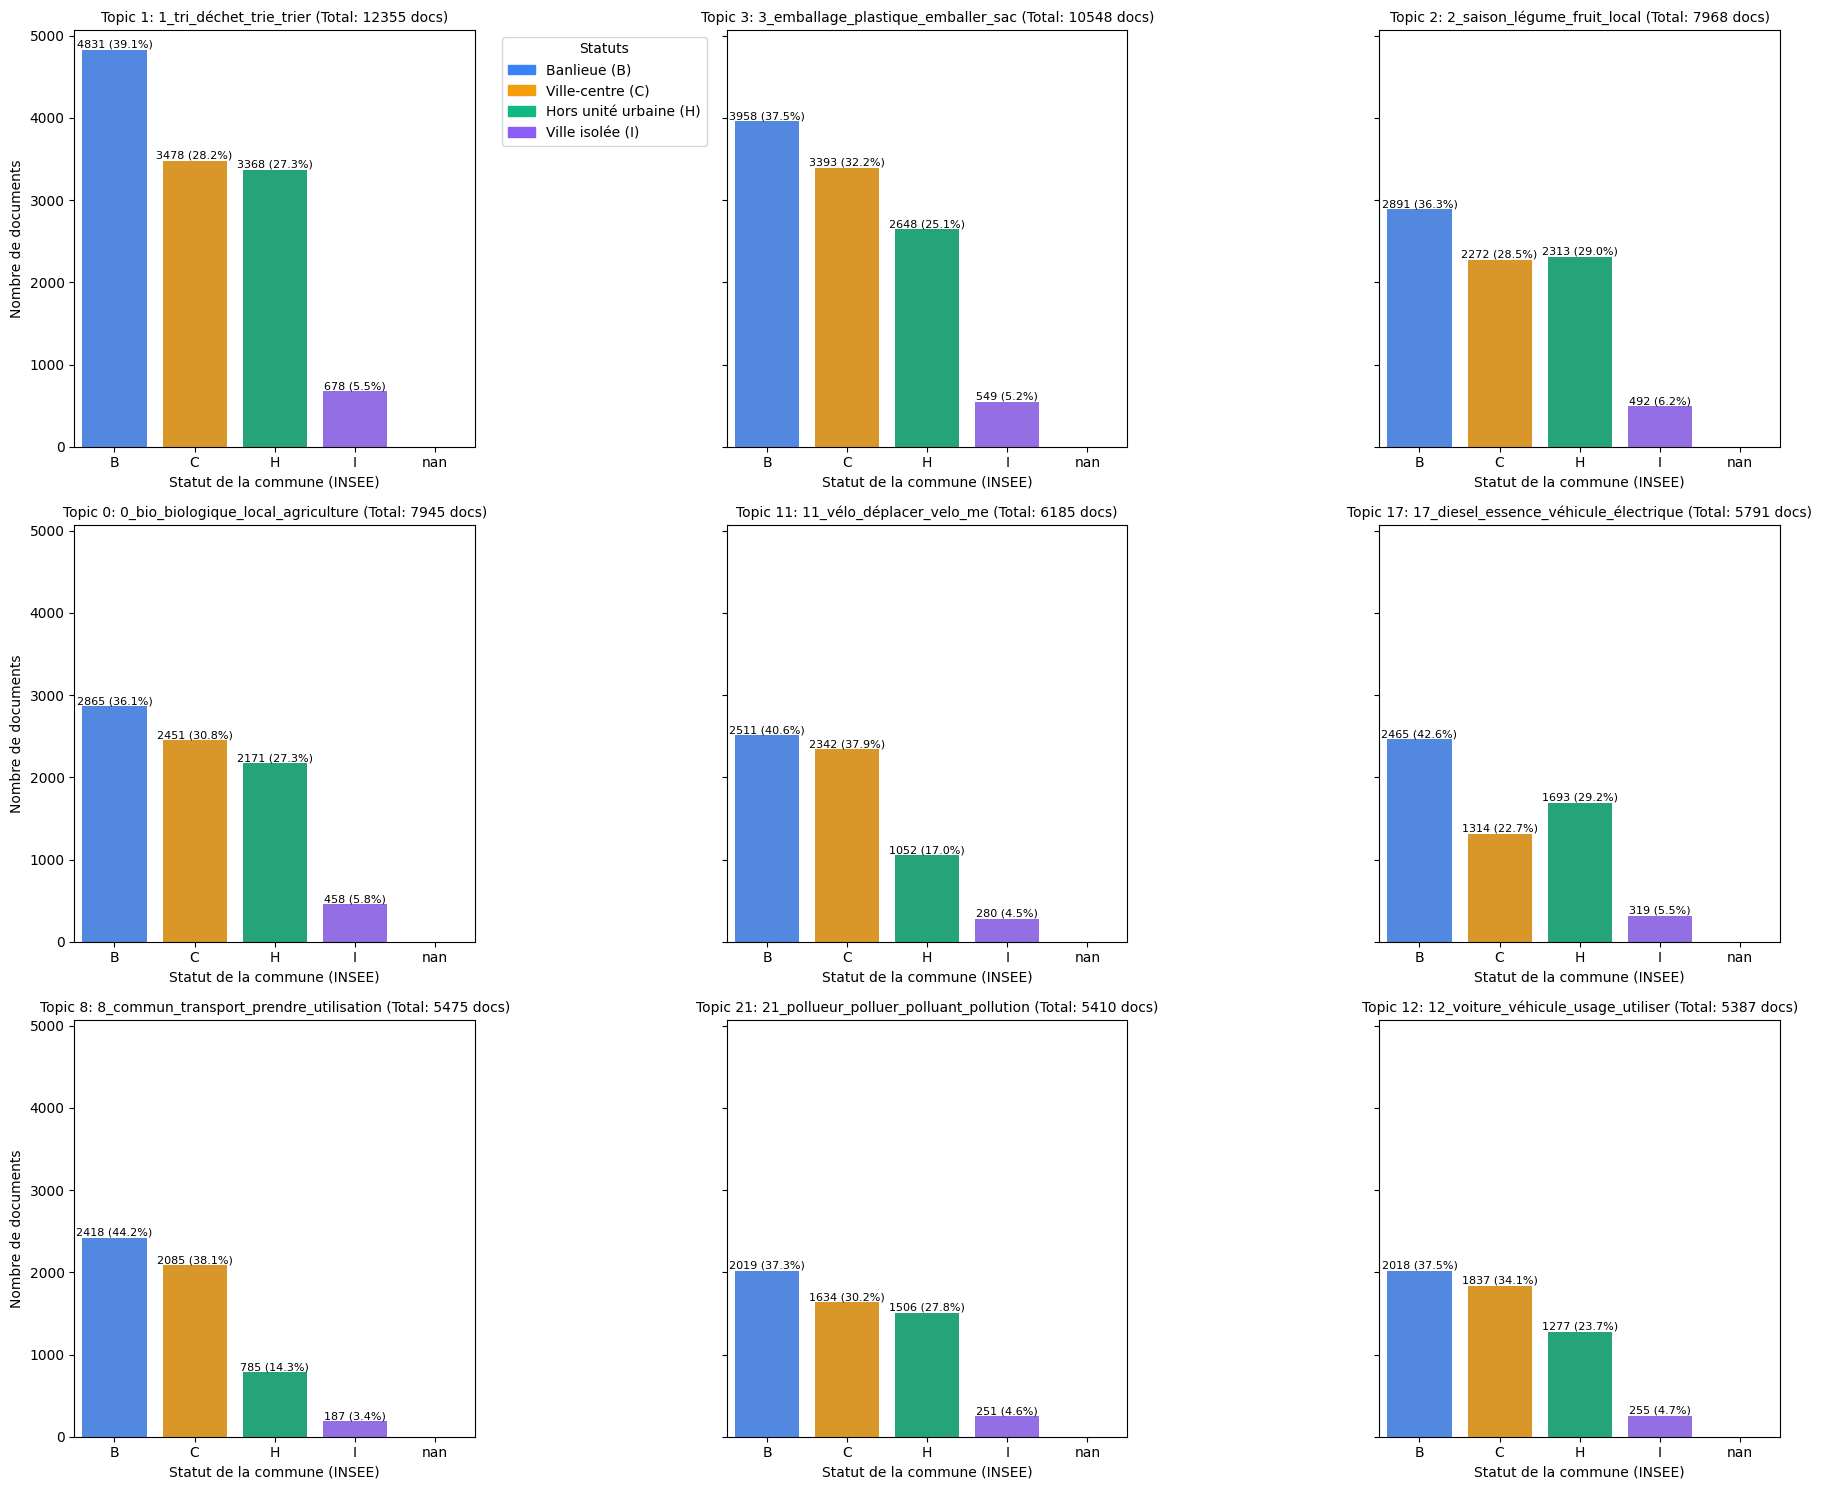

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer les top 9 topics par count total (excluant -1)
df_topics = df_filtered[df_filtered['topic_fusionne'] >= 0].copy()
top_topics = df_topics['topic_fusionne'].value_counts().head(9).index.tolist()

# Préparer la figure 
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharey=True)  # Sharey pour aligner les échelles Y
axes = axes.flatten()  # Pour itérer facilement

# Palette de couleurs
palette = ["#3b82f6", "#f59e0b", "#10b981", "#8b5cf6", "#6b7280"]

# boucle sur les top 9 topics pour générer chaque graphique
for idx, topic_id in enumerate(top_topics):
    # Filtrer les documents pour ce topic
    df_topic = df_filtered[df_filtered['topic_fusionne'] == topic_id].copy()
    
    # Récupérer le nom (pour titre seulement)
    topic_name = df_topic['def_topic_fusionne'].iloc[0] if not df_topic.empty else "Nom non disponible"
    
    # Nombre total de documents
    total_docs_topic = len(df_topic)
    
    # Standardisation de STATUT_COM_UU
    statut = df_topic["STATUT_COM_UU"].astype("string")
    statut = statut.replace({"NaN": pd.NA, "nan": pd.NA, "": pd.NA})
    statut = statut.fillna("nan")
    
    categories = pd.CategoricalDtype(categories=["B", "C", "H", "I", "nan"], ordered=True)
    df_topic["STATUT_COM_UU_std"] = statut.astype(categories)
    
    # Agrégation: comptage par statut
    docs_by_statut = (
        df_topic.groupby("STATUT_COM_UU_std", dropna=False, observed=True)
        .size()
        .rename("nb_docs")
        .reset_index()
    )
    
    # Calcul des pourcentages
    total_docs = docs_by_statut["nb_docs"].sum()
    docs_by_statut["pct_docs"] = np.where(total_docs > 0, (docs_by_statut["nb_docs"] / total_docs) * 100, np.nan)
    
    # Tri
    docs_by_statut = docs_by_statut.sort_values(by="STATUT_COM_UU_std", key=lambda s: s.cat.codes)
    
    # Données pour plot 
    plot_data = docs_by_statut.copy()  # Pas de Total ici, car on n'ajoute pas la ligne
    
    # barplot 
    ax = axes[idx]
    sns.barplot(data=plot_data, x="STATUT_COM_UU_std", y="nb_docs", palette=palette, ax=ax)
    
    # Étiquettes et titre
    ax.set_xlabel("Statut de la commune (INSEE)")
    ax.set_ylabel("Nombre de documents")
    ax.set_title(f"Topic {topic_id}: {topic_name} (Total: {total_docs_topic} docs)", fontsize=10)
    
    # Étiquettes au-dessus des barres
    for i, row in plot_data.iterrows():
        ax.text(i, row["nb_docs"], f"{row['nb_docs']} ({row['pct_docs']:.1f}%)", ha="center", va="bottom", fontsize=8)
    
    # Légende 
    if idx == 0:
        handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(plot_data))]
        labels = ["Banlieue (B)", "Ville-centre (C)", "Hors unité urbaine (H)", "Ville isolée (I)", "Non renseigné (nan)"]
        ax.legend(handles, labels, title="Statuts", bbox_to_anchor=(1.05, 1), loc='upper left')

# figure
plt.tight_layout()
plt.show()


Quelques commentaires sur la répartition des thèmes selon le statut des communes (B, C, H, I) :

Topic 1 : **1_tri_déchet_trie_trier** (le plus importants avec 12355 documents) :   

Les chiffres correspondent approximativement à la répartition des segments (B 37.5 %, C 29.1 %, H 27.9 %, I 5.4 %), avec des écarts mineurs.  
Ces différences minimes suggèrent que la préoccupation pour le tri des déchets semble également répartie et universelle à travers les territoires. Cela peut s'expliquer par l'omniprésence de ce thème dans les médias, où il est souvent présenté comme le minimum écologique à faire au quotidien, accessible à tous indépendamment du contexte urbain ou rural, favorisant ainsi une sensibilisation homogène.

Topic 3: **emballage_plastique_emballer_sac** (Total: 10548 docs)  

Les écarts par rapport à la répartition des segments sont plus marqués que pour d'autres topics, avec une sur-représentation notable des villes-centres et une sous-représentation des zones rurales, tandis que les banlieues (B) et villes isolées (I) restent relativement stables.   
Malgré ces variations, le topic reste bien réparti globalement, sans déséquilibre extrême.    
Cette sur-représentation en villes-centres (C) pourrait refléter une plus grande exposition aux problématiques des emballages plastiques dans des environnements urbains denses, où la consommation de produits emballés est plus intensive (supermarchés, e-commerce) et où les campagnes de sensibilisation anti-plastique (ex. : interdictions de sacs plastiques) sont plus visibles et promues par les autorités locales. 
À l'inverse, la sous-représentation en zones rurales (H) s'explique potentiellement par des modes de vie plus autosuffisants, avec un recours accru aux produits locaux non emballés (marchés fermiers, circuits courts) et une moindre dépendance aux emballages jetables.  
Globalement, la bonne répartition suggère que la réduction des plastiques est une préoccupation écologique transversale, influencée par le degré d'urbanisation et l'accès à des alternatives durables.

Topic 2: **saison_légume_fruit_local** (Total: 7966 docs)

  
Les écarts par rapport à la répartition des segments sont relativement mineurs.  
Une légère sur-représentation en zones rurales (H) et villes isolées (I) pourrait s'expliquer par une plus grande proximité avec les circuits courts et les productions locales (ex. : marchés fermiers, autoconsommation de fruits et légumes de saison), rendant ce thème plus naturel et prépondérant dans ces contextes où l'accès direct aux produits frais est facilité.  
À l'inverse, les environnements urbains (B et C) pourraient le mentionner moins, en raison d'une dépendance accrue aux supermarchés et importations, où les produits de saison locaux sont moins visibles ou accessibles, malgré des initiatives croissantes comme les AMAP.  
Globalement, la répartition homogène reflète l'attrait universel pour une consommation locale et de saison, promue comme une action écologique simple et bénéfique pour l'économie territoriale, influencée toutefois par les opportunités géographiques.

Topic 11: **vélo_déplacer_velo_me** (Total: 6185 docs)

Les écarts par rapport à la répartition des segments sont plus prononcés, avec une sur-représentation marquée des villes-centres (plus légère pour les banlieues), contrastant avec une forte sous-représentation des zones rurales et une plus faible pour les villes isolées. Ces variations indiquent un déséquilibre plus net que pour d'autres topics, bien que le thème reste présent dans tous les territoires.  

Cette sur-représentation en environnements urbains denses (C et B) pourrait s'expliquer par la pertinence accrue du vélo comme mode de déplacement quotidien dans ces zones, où les distances sont souvent courtes, les embouteillages fréquents, et les infrastructures (pistes cyclables, vélos en libre-service) plus développées, favorisant son adoption comme alternative écologique à la voiture.    
À l'inverse, la sous-représentation en zones rurales (H) reflète les contraintes géographiques (distances plus longues, manque d'aménagements sécurisés), rendant le vélo moins pratique et moins prioritaire face à la dépendance automobile.    
Les villes isolées (I) montrent une tendance similaire, quoique modérée, due à une urbanisation intermédiaire.

Globalement, bien que le topic soit bien réparti en termes de présence, son intensité est influencée par l'urbanisation, soulignant comment les actions écologiques comme le vélo dépendent fortement des contextes infrastructurels et des besoins en mobilité.

Topic 17: **diesel_essence_véhicule_électrique** (Total: 5791 docs)

Les écarts par rapport à la répartition des segments sont notables, avec une sur-représentation des banlieues et une plus légère pour les zones rurales, contrastant avec une sous-représentation marquée des villes-centres, tandis que les villes isolées (I) restent stables.  
Ces variations indiquent un déséquilibre modéré, orienté vers les zones périurbaines et rurales, sans exclure aucun territoire.

Cette sur-représentation en banlieues (B) pourrait refléter une plus grande dépendance à la voiture individuelle pour les trajets domicile-travail vers les centres urbains, où la transition des véhicules diesel/essence vers l'électrique est perçue comme une solution écologique et économique (réduction des émissions, aides fiscales), d'autant plus que ces zones bénéficient souvent d'un accès croissant aux infrastructures de recharge.  
La légère sur-représentation en zones rurales (H) s'explique potentiellement par la prédominance du diesel pour les longs trajets et les activités agricoles, rendant le débat sur les véhicules électriques plus saillant face aux contraintes d'autonomie et de coûts, amplifiées par un manque de bornes.  
À l'inverse, la sous-représentation en villes-centres (C) pourrait découler d'une moindre utilisation de la voiture personnelle, favorisée par des alternatives comme les transports en commun ou le vélo, reléguant ce thème au second plan. Globalement, la répartition reste équilibrée, illustrant comment la transition énergétique automobile est une préoccupation transversale, mais modulée par le degré de dépendance à la voiture et l'accès aux technologies vertes selon les contextes territoriaux.

Topic 8: **commun_transport_prendre_utilisation** (Total: 5475 docs)

Les écarts par rapport à la répartition des segments sont particulièrement prononcés, avec une sur-représentation marquée des villes-centres et des banlieues, contrastant avec une forte sous-représentation des zones rurales et une modérée pour les villes isolées.  
Ces variations indiquent un déséquilibre net, orienté vers les environnements urbains denses, bien que le thème reste présent dans tous les territoires.  
Cette sur-représentation en villes-centres (C) et banlieues (B) pourrait s'expliquer par la disponibilité et l'utilisation quotidienne accrue des transports en commun (bus, métro, trains) dans ces zones, où ils constituent une alternative écologique et pratique à la voiture individuelle, favorisée par des réseaux denses et des politiques de mobilité durable (ex. : passes Navigo, incitations fiscales).  
À l'inverse, la forte sous-représentation en zones rurales (H) et, dans une moindre mesure, en villes isolées (I) découle probablement d'un manque d'infrastructures de transport public (fréquences basses, couverture limitée), rendant cette option moins viable et moins mentionnée, au profit d'une dépendance à la voiture personnelle. Globalement, bien que le topic soit bien réparti en termes de présence minimale, son intensité est fortement influencée par l'urbanisation et l'accès aux services collectifs, soulignant comment les actions écologiques liées à la mobilité collective dépendent des investissements infrastructurels territoriaux.

## Topics dont la répartition est la plus différente par rapport à la répartition des segments

Nous avons intégré la **divergence de Jensen-Shannon** (JSD) comme métrique pour identifier les topics dont la répartition par statut de commune s'éloigne le plus des proportions globales des segments. Cette méthode, issue de la théorie de l'information, permet de quantifier de manière robuste les écarts entre distributions de probabilités.

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon  
from typing import List

# Proportions brutes globales (normalisées pour sommer à 1)
global_proportions = np.array([0.375, 0.291, 0.279, 0.054])  

# Fonction pour calculer les proportions normalisées d'un topic
def get_topic_proportions(row: pd.Series) -> np.ndarray:
    counts = np.array([row.get('Count_B', 0), row.get('Count_C', 0), row.get('Count_H', 0), row.get('Count_I', 0)])
    total = counts.sum()
    if total == 0:
        return np.zeros(4)  # Évite division par zéro
    return counts / total

# Fonction pour calculer la JSD entre deux distributions
def calculate_jsd(p: np.ndarray, q: np.ndarray) -> float:
    return jensenshannon(p, q)  # Retourne la racine carrée de la JS divergence (valeur entre 0 et 1)

# Filtrer pour ignorer les NaN dans STATUT_COM_UU (statut de la commune)
df_filtered_clean = df_filtered.dropna(subset=['STATUT_COM_UU'])  # Remplacez 'STATUT_COM_UU' par le nom réel si différent

# Calculer les counts par topic et statut (groupe par topic_fusionne et STATUT_COM_UU, compte les lignes/documents)
df_counts = df_filtered_clean.groupby(['topic_fusionne', 'STATUT_COM_UU']).size().reset_index(name='Count')

# Pivoter pour avoir une colonne par statut 
df_pivot = df_counts.pivot(index='topic_fusionne', columns='STATUT_COM_UU', values='Count').fillna(0).reset_index()
df_pivot.columns = ['Topic'] + [f'Count_{col}' for col in df_pivot.columns[1:]]  # Renommer en Count_B, Count_C, etc.

# Extraire un mapping unique des noms de topics (Topic -> Topic_Name)
topic_names_mapping = df_filtered_clean[['topic_fusionne', 'def_topic_fusionne']].drop_duplicates().set_index('topic_fusionne')['def_topic_fusionne'].to_dict()

# Ajouter la colonne Topic_Name au dataframe pivoté
df_topics = df_pivot.copy()
df_topics['Topic_Name'] = df_topics['Topic'].map(topic_names_mapping)

# Calcul des proportions et JSD pour chaque topic
df_topics['Proportions'] = df_topics.apply(get_topic_proportions, axis=1)  # Vecteur [B, C, H, I] (ordre alphabétique assumé)
df_topics['JSD'] = df_topics['Proportions'].apply(lambda p: calculate_jsd(p, global_proportions))

# Tri par JSD décroissante (les plus éloignés en premier)
df_sorted = df_topics.sort_values(by='JSD', ascending=False)

# Sélection des top N les plus éloignés
top_n = 20
selected_topics = df_sorted.head(top_n)

# Affichage des résultats 
print("Topics les plus éloignés de la répartition brute (triés par JSD décroissante):")
print(selected_topics[['Topic', 'Topic_Name', 'JSD']])

Topics les plus éloignés de la répartition brute (triés par JSD décroissante):
     Topic                                         Topic_Name       JSD
246    251                           251_voiture_pas_avoir_je  0.311801
231    236                             236_chauffe_bois_me_au  0.277776
176    180                           180_voiture_pas_avoir_ne  0.273818
264    270  270_moulin_hydroélectricité_hydroélectrique_si...  0.234712
195    199                           199_voiture_plus_vélo_ne  0.230329
267    273                         273_métro_tram_tramway_bus  0.217917
106    108                 108_campagne_rural_habiter_village  0.214409
88      90                    90_pied_marche_commun_transport  0.211531
213    218                 218_habiter_ville_centre_déménager  0.208953
274    280                  280_tondre_pelouse_tonte_tondeuse  0.190072
121    124                         124_bois_chauffage_au_font  0.180730
290    297                       297_granulé_bois_granule

Nous avons identifié les topics dont la répartition par statut de commune (Banlieue 'B', Ville-centre 'C', Hors unité urbaine 'H', Ville isolée 'I') s'éloigne le plus de la répartition brute globale, mesurée via la divergence de Jensen-Shannon (JSD). Les résultats mettent en évidence des écarts significatifs pour une vingtaine de topics, triés par JSD décroissante. Ces topics illustrent bien des thématiques qui ne concernent pas les communes selon leur statut de la même manière, révélant des disparités liées au contexte géographique et socio-économique.

Parmi ces topics, plusieurs apparaissent comme purement ruraux, reflétant des préoccupations spécifiques aux zones hors unité urbaine ('H') ou isolées ('I'), où les modes de vie sont souvent plus autonomes et liés à l'environnement immédiat. Par exemple :  

Le topic 236 (**chauffe_bois_me_au**) et 124 (**bois_chauffage_au_font**) mettent l'accent sur le chauffage au bois, une pratique courante en milieu rural pour des raisons d'accès aux ressources locales et d'autonomie énergétique.  
Le topic 100 (**poule_oeuf_œuf_élever**) évoque l'élevage de poules et la production d'œufs, typique des habitudes d'autosuffisance en campagne.  
Le topic 82 (**permaculture_potager_cultiver_jardin**) souligne la permaculture et le jardinage, des activités facilitées par l'espace disponible en zones rurales.    
D'autres comme 270 (**moulin_hydroélectricité_hydroélectrique_si...**) sur l'hydroélectricité ou 141 (**bois_chauffage_forêt_mort**) sur l'exploitation forestière renforcent cette tendance, en lien avec des ressources naturelles abondantes en milieu rural.  

À l'inverse, des sujets purement urbains émergent, davantage portés par les habitants de villes-centres ('C') ou banlieues ('B'), où les infrastructures collectives et la densité influencent les comportements. Par exemple :  

Le topic 273 (**métro_tram_tramway_bus**) et 90 (**pied_marche_commun_transport**) se concentrent sur les transports en commun, la marche ou les déplacements piétons, des solutions adaptées aux environnements denses et bien desservis des zones urbaines.  
Les topics 218 (**habiter_ville_centre_déménager**) et 213 (**ville_centre_urbain_habiter**) traitent de l'habitation en centre-ville ou des déménagements urbains, reflétant les défis de la vie en milieu citadin comme la mobilité et l'accès aux services.  
Le topic 280 (**tondre_pelouse_tonte_tondeuse**) pourrait sembler anecdotique mais pointe vers des préoccupations d'entretien d'espaces verts en contexte péri-urbain ou banlieusard.  

Malgré ces disparités, il est notable que ces topics ont des numéros élevés (généralement supérieurs à 100, comme 251, 236 ou 270), ce qui indique qu'ils correspondent à des clusters plus petits et spécifiques dans notre modélisation BERTopic (même après fusion de quelques topics).  
En revanche, les plus gros topics (les premiers numéros, souvent plus généraux) respectent mieux les proportions générales, suggérant une uniformité plus grande pour les thématiques dominantes.

# Approche alternative avec LLM

Dans la section suivante du rapport, nous présentons une approche alternative pour la segmentation textuelle des réponses ouvertes du dataset, en nous basant sur le LLM **Qwen2.5-1.5B-Instruct**, plutôt que sur des règles syntaxiques prédéfinies.  
Cette stratégie LLM exploite les capacités sémantiques avancées des modèles pré-entraînés pour identifier et séparer automatiquement les idées ou actions distinctes dans les textes, en générant des segments simplifiés et normalisés. Elle offre une flexibilité accrue face à la variabilité des réponses (phrases informelles, listes implicites, ou enchaînements complexes), en "comprenant" le contexte pour produire des splits plus intelligents que des règles rigides.  
Cependant, cette méthode dépend de ressources computationnelles significatives (mémoire GPU/CPU et temps d'inférence), et nécessite un prompt engineering fin (avec few-shot learning pour guider la sortie) pour éviter des hallucinations ou des ajouts non désirés.  

Nous utilisons ici un prompt système strict pour contraindre la sortie : français uniquement, segments séparés par des points, simplification des expressions (ex. : "je trie mes déchets" → "trier déchets"), tout en minuscules, sans numérotation ni explications.  
Nous testons l'approche sur une liste d'exemples représentatifs pour évaluer son efficacité.  


In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"  # Désactive les warnings spécifiques à transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)  # Supprime les autres messages


import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Masque spécifiquement les UserWarnings

model_name = "Qwen/Qwen2.5-1.5B-Instruct"
tok = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
mdl = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32, trust_remote_code=True)
mdl.to("cpu")

def segment_semantic_qwen(text: str) -> list[str]:
    sys_msg = (
        "tu es un assistant de normalisation de texte. "
        "tâche: séparer les idées/actions distinctes par un point et simplifier chaque idée. "
        "contraintes: 1) français uniquement, 2) séparateur='.', 3) simplifie: "
        "\"économie de l'eau\"->\"économie eau\", \"je trie mes déchets\"->\"trier déchets\", "
        "4) ne rien ajouter, 5) tout en minuscules, 6) pas d'explication, pas de numérotation."
    )

    fewshot_in = "je trie mes déchets, je fais du compost, j'utilise mon vélo pour les petits trajets"
    fewshot_out = "trier déchets. faire compost. utiliser vélo petit trajet."

    user_msg = (
        f"exemple:\ntexte: {fewshot_in}\nsortie: {fewshot_out}\n\n"
        f"texte: {text}\nsortie:"
    )

    messages = [
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": user_msg},
    ]

    # Construire la chaîne de prompt 
    prompt_str = tok.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)

    # tokenisation
    inputs = tok(prompt_str, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Jeton fin de message Qwen
    im_end_id = tok.convert_tokens_to_ids("<|im_end|>") or tok.eos_token_id
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else im_end_id

    # Génération déterministe (pas de sampling → pas de temperature/top_k/top_p)
    out = mdl.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=96,
        do_sample=False,
        num_beams=1,
        repetition_penalty=1.05,
        eos_token_id=im_end_id,
        pad_token_id=pad_id,
        use_cache=True,
    )

    # Décoder les nouveaux tokens
    gen_only = out[0, input_ids.shape[-1]:]
    resp = tok.decode(gen_only, skip_special_tokens=True).strip().lower()
    resp = re.sub(r"\s+", " ", resp).split("\n")[0]

    segs = [s.strip(" .") for s in resp.split(".") if s.strip(" .")]
    blacklist = ("sépare", "identify", "règles", "instruction", "expliquer", "explanation")
    segs = [s for s in segs if not any(w in s for w in blacklist)]
    return segs

# Test 
if __name__ == "__main__":
    samples = [
        "je prends les transports en commun et j'évite la voiture autant que possible",
        "amélioration de l'isolation de mon domicile changement de la chaudière à gaz vers une chaudière à condensation à gaz je fais aussi attention à ma consommation d'eau",
        "Eco conduite, utilisation de l'eau de pluie pour le jardinage, mise en place de ruches pour lutter contre la disparition des abeilles, réduire le chauffage",
        "Limiter les déplacements en voiture et favoriser si possible les transports en communs",
        "Le tri sélectif plus achats de produits locaux et éviter les produits alimentaires de type industriel",
        "Je n'utilise ma voiture que parcimonieusement sinon c'est marche, vélo ou transports en commun. Je trie mes déchets avec un compost dans le jardin.",
        "Je prends des douches au lieu de bains, triage des dechets, utilisation limite de plastique, economie d'energis (chauffage pas pllus de 20d.)etc."
    ]
    for t in samples:
        print("\nInput:", t)
        print("Segments:", segment_semantic_qwen(t))



Input: je prends les transports en commun et j'évite la voiture autant que possible
Segments: ['prendre transports en commun', 'éviter voiture']

Input: amélioration de l'isolation de mon domicile changement de la chaudière à gaz vers une chaudière à condensation à gaz je fais aussi attention à ma consommation d'eau
Segments: ['améliorer isolation domicile', 'changer chaudière gaz vers condensation gaz', 'faire attention consommation eau']

Input: Eco conduite, utilisation de l'eau de pluie pour le jardinage, mise en place de ruches pour lutter contre la disparition des abeilles, réduire le chauffage
Segments: ['conduite', 'utiliser eau pluie jardinage', 'mettre ruches lutter disparition abeilles', 'réduire chauffage']

Input: Limiter les déplacements en voiture et favoriser si possible les transports en communs
Segments: ['limiter déplacements voiture', 'favoriser transport commun']

Input: Le tri sélectif plus achats de produits locaux et éviter les produits alimentaires de type ind

Cette segmentation produit des segments propres et concis, augmentant le nombre d'unités analysables tout en préservant la traçabilité vers les documents originaux.

L'utilisation d'un LLM comme Qwen s'avère très efficace pour la segmentation sémantique, car elle permet de "sauter" de nombreuses étapes manuelles de pré-traitement (telles que la définition exhaustive de règles regex ou la gestion de cas limites syntaxiques), en produisant directement des segments cohérents et simplifiés grâce à une compréhension contextuelle avancée.  
Cependant, le temps de calcul est rédhibitoire pour de grands datasets, rendant cette approche impraticable sur l'ensemble du corpus du Grand Débat National sans ressources hardware dédiées (les ressources gratuites de Kaggle ne suffisent pas ici).  
Nous avons essayé plusieurs LLM (tels que **Flan-T5**, **Mistral** ou **Llama**) avant d'obtenir de bons résultats avec Qwen, qui se distingue par sa précision dans le respect des contraintes du prompt. 

Cette méthode gagnera en attractivité à mesure que les modèles locaux deviendront plus accessibles en termes de taille, de prix (optimisations open-source gratuites) et d'efficacité énergétique, permettant une intégration fluide dans des workflows locaux sans dépendre de puissants serveurs distants et payants.

# Conclusion 


L’étape de segmentation a été la plus délicate. Le paramétrage d’un découpage rule‑based s’est révélé sensible aux abréviations, aux énumérations et à la ponctuation hétérogène. De petits changements de règles entraînaient des variations notables du nombre et de la qualité des segments. Nos choix quant aux seuils d’évacuation des petits segments restent en partie arbitraires. Ils mériteraient une analyse de sensibilité systématique en testant plusieurs seuils et en comparant les résultats via des métriques de stabilité et une revue qualitative.  

Concernant l'étape de *topic modeling* (BERTopic): l’ajustement des hyperparamètres a demandé de nombreux essais. En particulier, UMAP (n_neighbors, min_dist), HDBSCAN (min_cluster_size, min_samples) et le vectorizer (n‑grams, min_df, stop‑list) influencent fortement la granularité et la stabilité des thèmes.

Ouvertures analytiques: 

L'analyse pourrait être complétée par l'étude du ton des contributions (polarité/subjectivité), ainsi que l'exploration de l’opposition "collectif vs individuel" via des classifieurs supervisés et des tests d’écarts entre segments. 

La réalisation d’une choroplèthe de la prévalence d’un topic par commune serait un axe également intéressant à approfondir.